# Notebook to evaluate inferred microbial anomaly scores

To run this notebook you need to create and activate the following conda environment:

```
conda create --name score_eval numpy pandas matplotlib seaborn scipy ipython ipykernel -y
conda activate score_eval
pip install -e .
```


## Setup

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils_eval_score import (
    _transform_scores,
    _plot_score_over_age, 
    _get_abx_info,
    _select_samples_around_nth_abx_exposure,
    _plot_score_after_nth_abx_exposure,
    display_scatterplot_w_scores,
    plot_trajectory
)

%load_ext autoreload
%autoreload 2
%matplotlib inline

# avg. number of days per month
DAYS_PER_MONTH = 30.437

USER input: define the inferred model and linked datasets to evaluate here:

In [2]:
#### USER INPUT START
# name of the model
model_name = "saved_models_microbial_alpha_div/id-102"
# which model version to evaluate: "best" or "last"
point_to_evaluate = "last"

# name of feature dataset used for model
ft_name = "ft_vat19_anomaly_v20240105_genus"
# name of abx time-series used for model
abx_ts_name = "ts_vat19_abx_v20240105"

#### USER INPUT END

## Prepare data

In [3]:
scores_path = f"../data/{model_name}/anomaly_detection/scores_{point_to_evaluate}/"
evaluation_path = f"../data/{model_name}/anomaly_detection/evaluation_{point_to_evaluate}/"

if not os.path.exists(evaluation_path):
    os.makedirs(evaluation_path)

split = "both"
# get train
train_ad_scores = pd.read_csv(f"{scores_path}train_ad_scores.csv")
scores_train = _transform_scores(train_ad_scores)

# get val
val_ad_scores = pd.read_csv(f"{scores_path}val_ad_scores.csv")
scores_val = _transform_scores(val_ad_scores)

In [4]:
# get noabx samples per split
noabx_train = scores_train[~scores_train["abx"]].copy()
noabx_val = scores_val[~scores_val["abx"]].copy()

In [5]:
# merge all abx scores into one group: train + val
abx_scores_flat = scores_train[scores_train["abx"]].copy()
abx_scores_flat_val = scores_val[scores_val["abx"]].copy()

abx_scores_flat = pd.concat([abx_scores_flat, abx_scores_flat_val])

# keep only rows that have a score
abx_scores_flat = abx_scores_flat[abx_scores_flat.score.notnull()].copy()

In [6]:
# add metadata matching samples over time from ft
ft_df = pd.read_csv(f"../data/original_data/{ft_name}.tsv", sep="\t", index_col=0)
ft_df["age_days"] = ft_df["age_days"].astype(int)
ft_df.rename(columns={"age_days": "day"}, inplace=True)

cols_to_evaluate = ["abx_any_cumcount", "abx_max_count_ever", "abx_any_last_t_dmonths", "abx_any_last_dur_days", "geo_location_name"]
ft_df = ft_df[["day", "host_id"] + cols_to_evaluate].copy()
ft_df = ft_df.assign(
    max_abx_w_microbiome=lambda df: df.groupby("host_id")["abx_any_cumcount"].transform(
        "max"
    ),
)
# add additional information to inferred scores
abx_scores_flat = abx_scores_flat.merge(ft_df, on=["host_id", "day"], how="left")

## Score after abx exposure 1st, 2nd and 3rd

abx train + val were both not used for training

In [7]:
path_to_abx_ts = f"../data/original_data/{abx_ts_name}.tsv"
abx_df = _get_abx_info(path_to_abx_ts)

/Users/adamova/miniforge3/envs/score_eval/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/Users/adamova/miniforge3/envs/score_eval/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


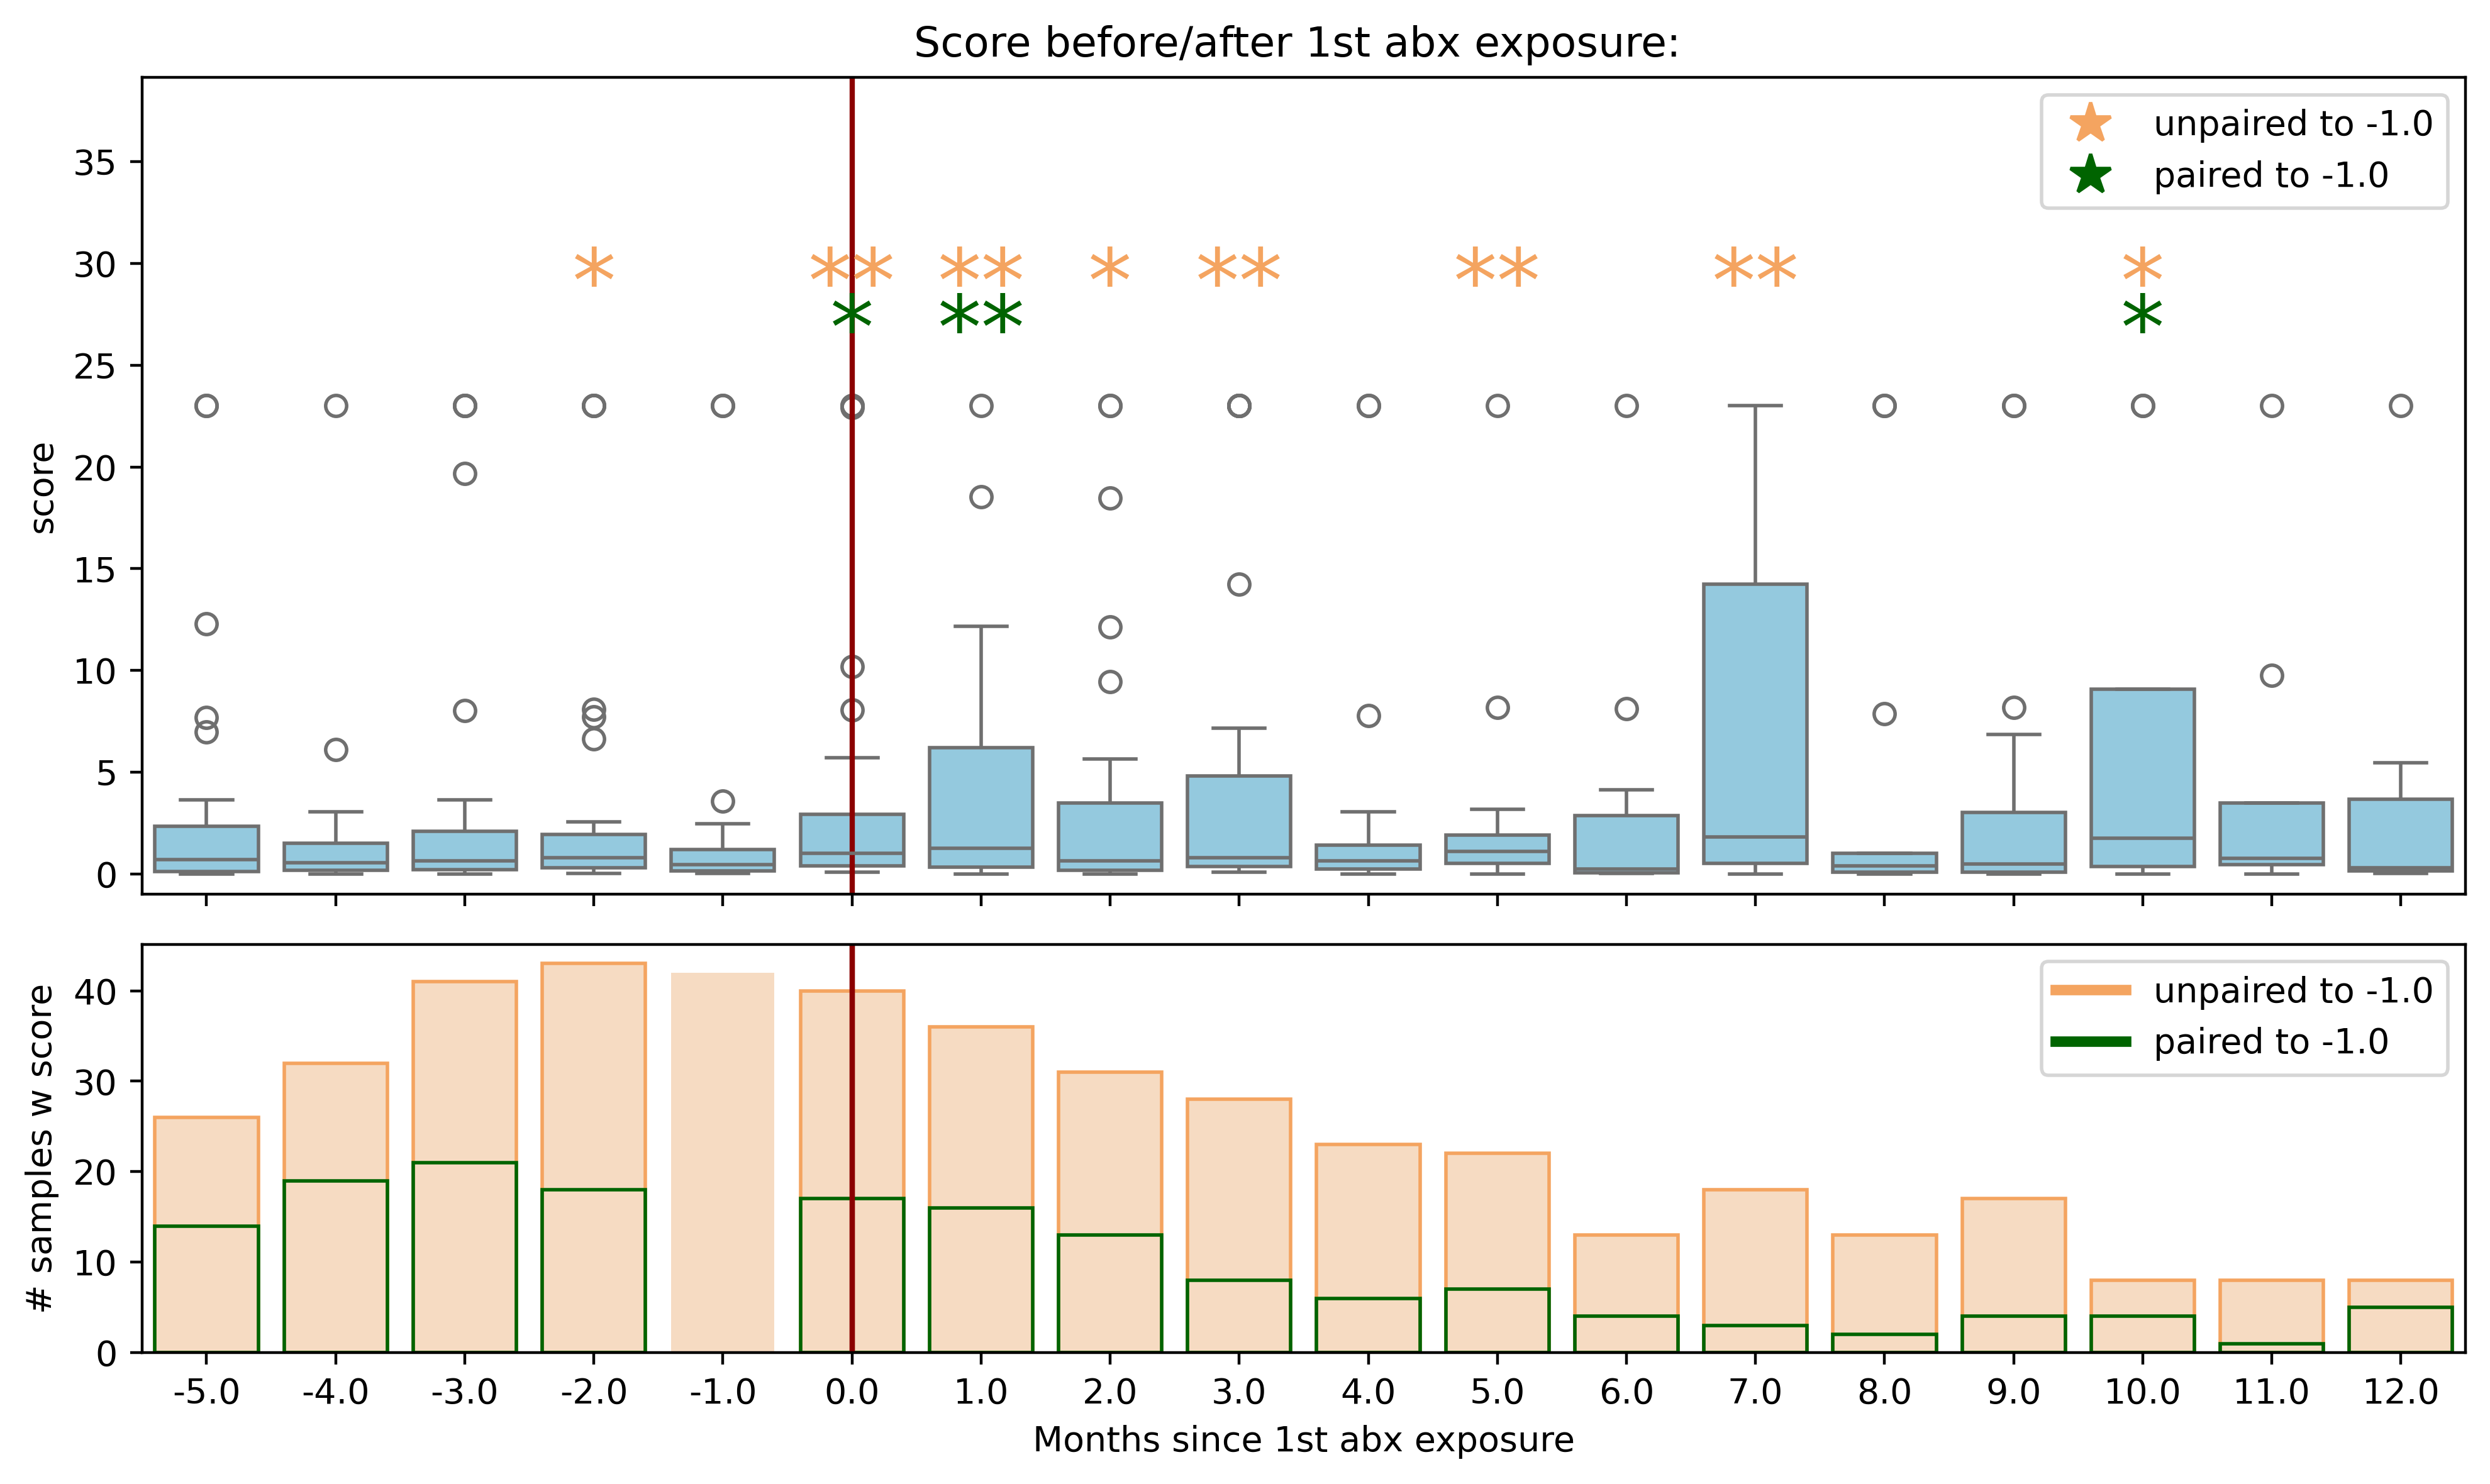

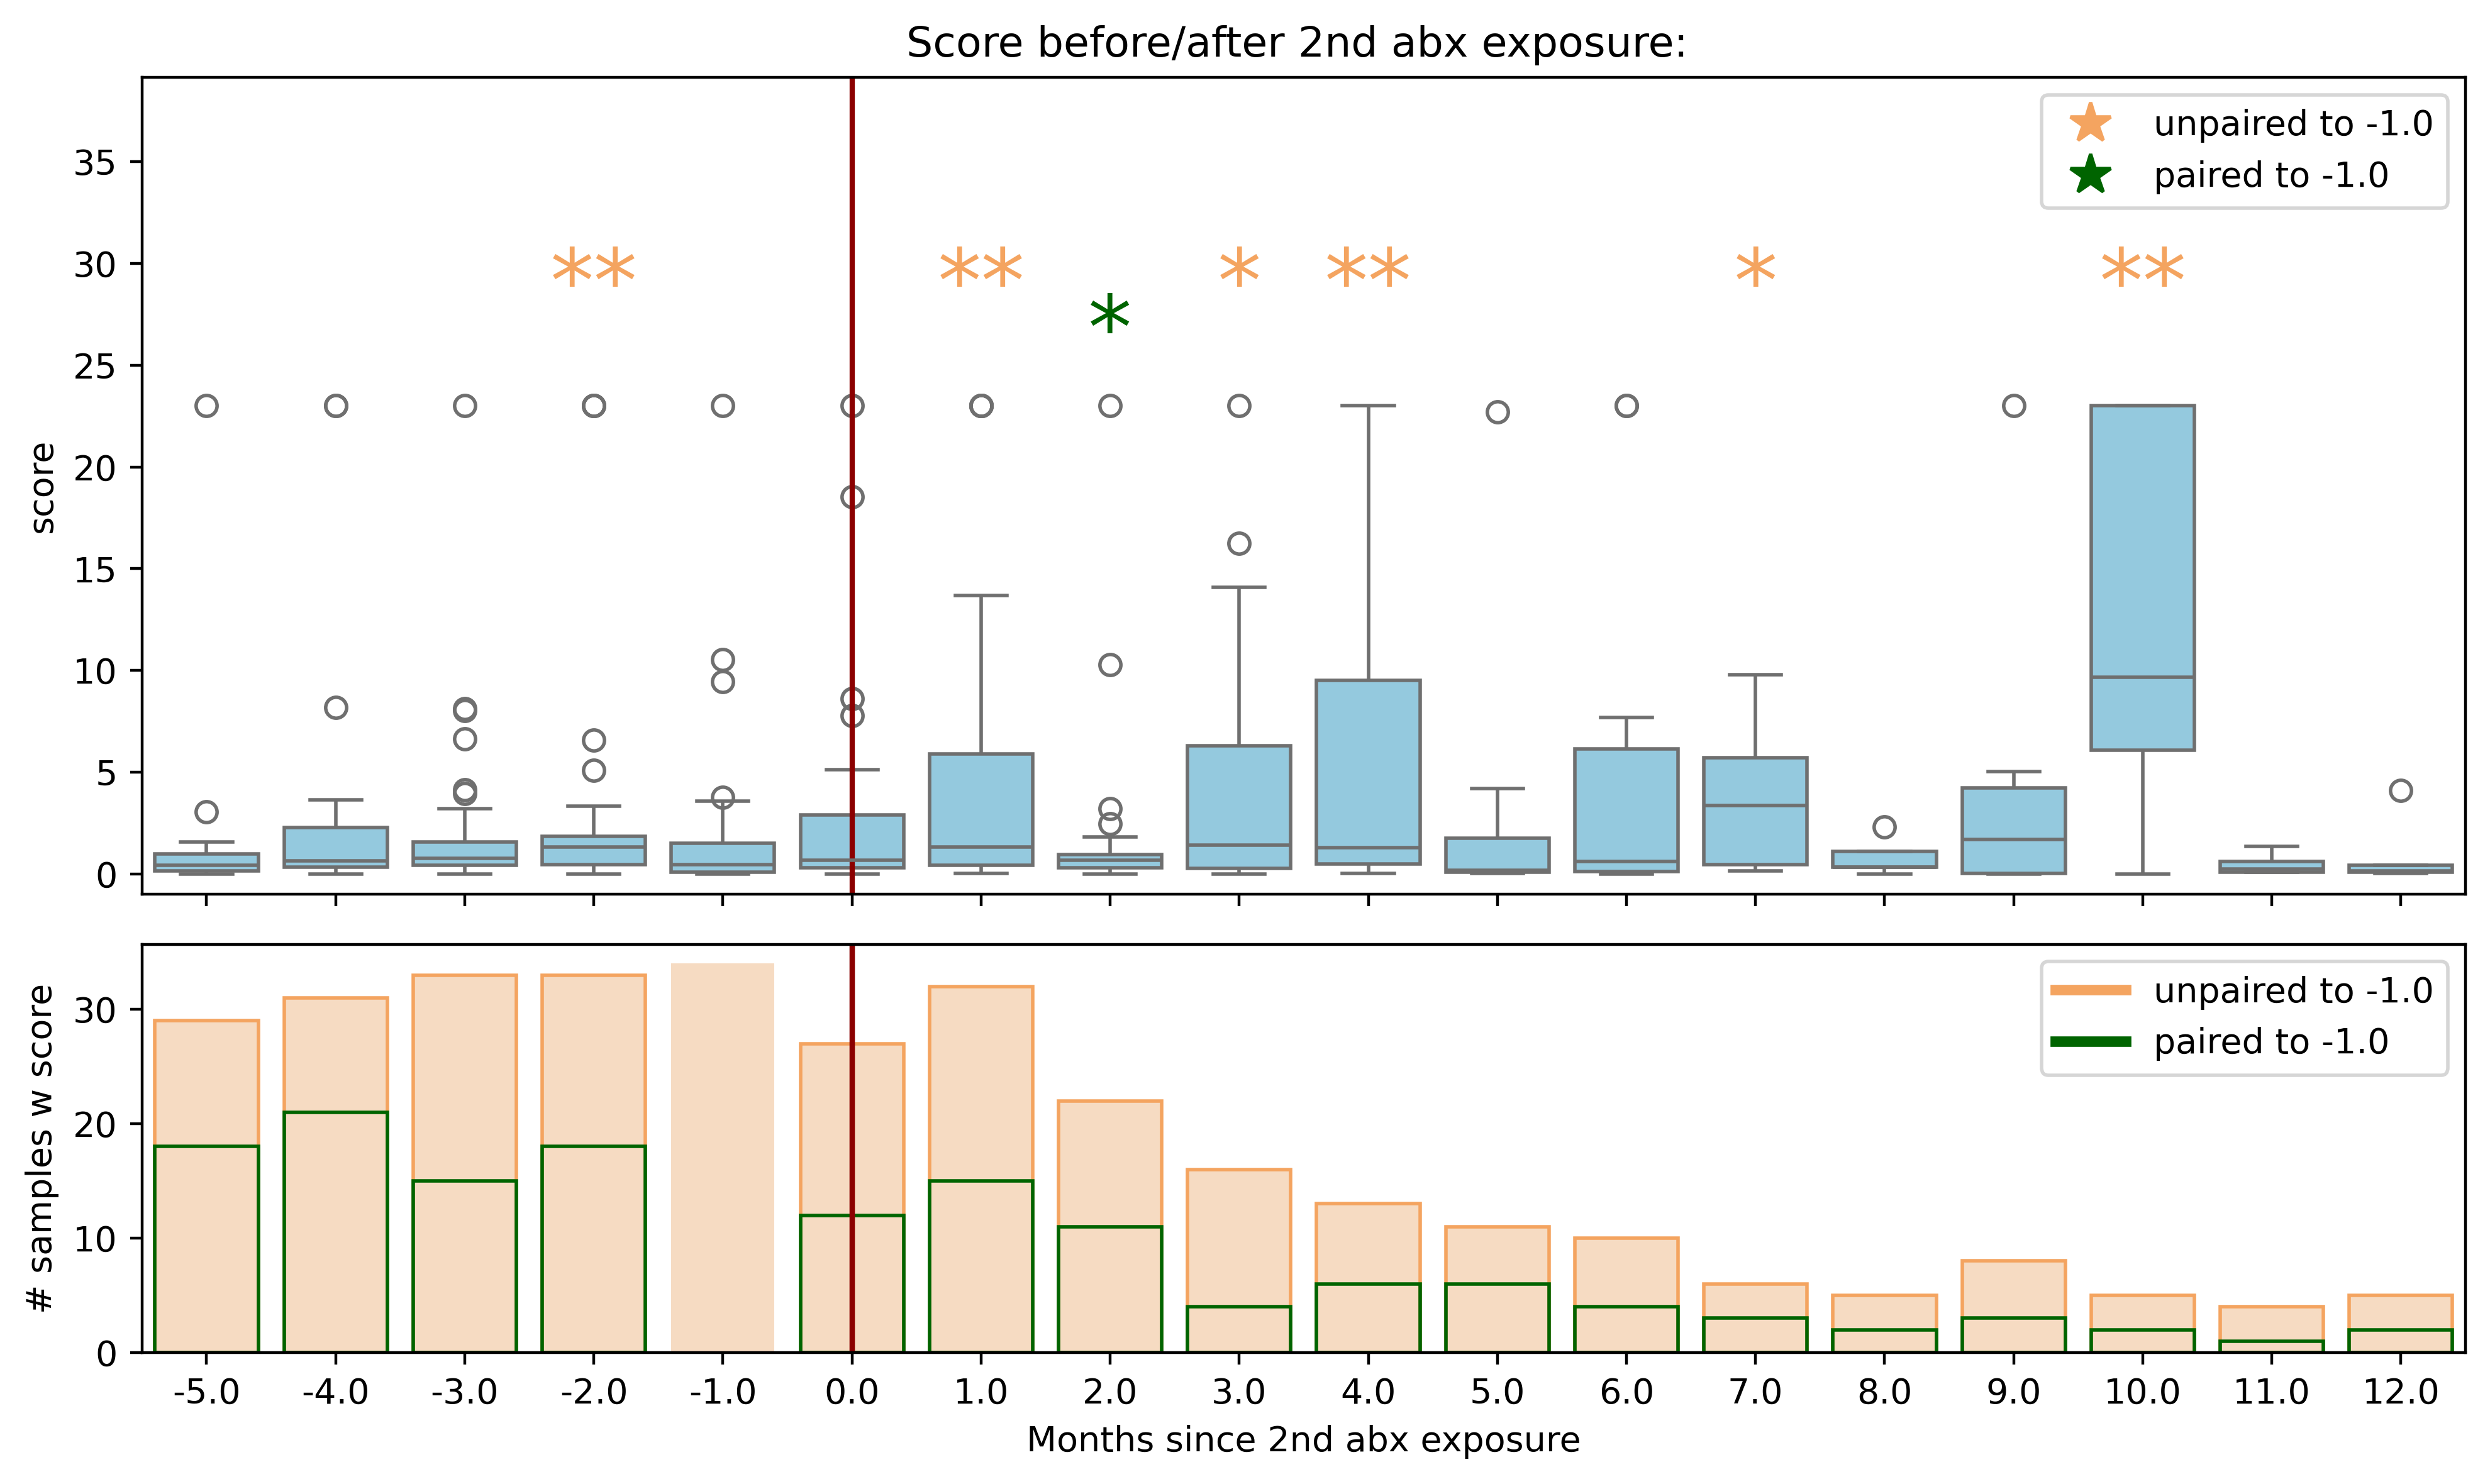

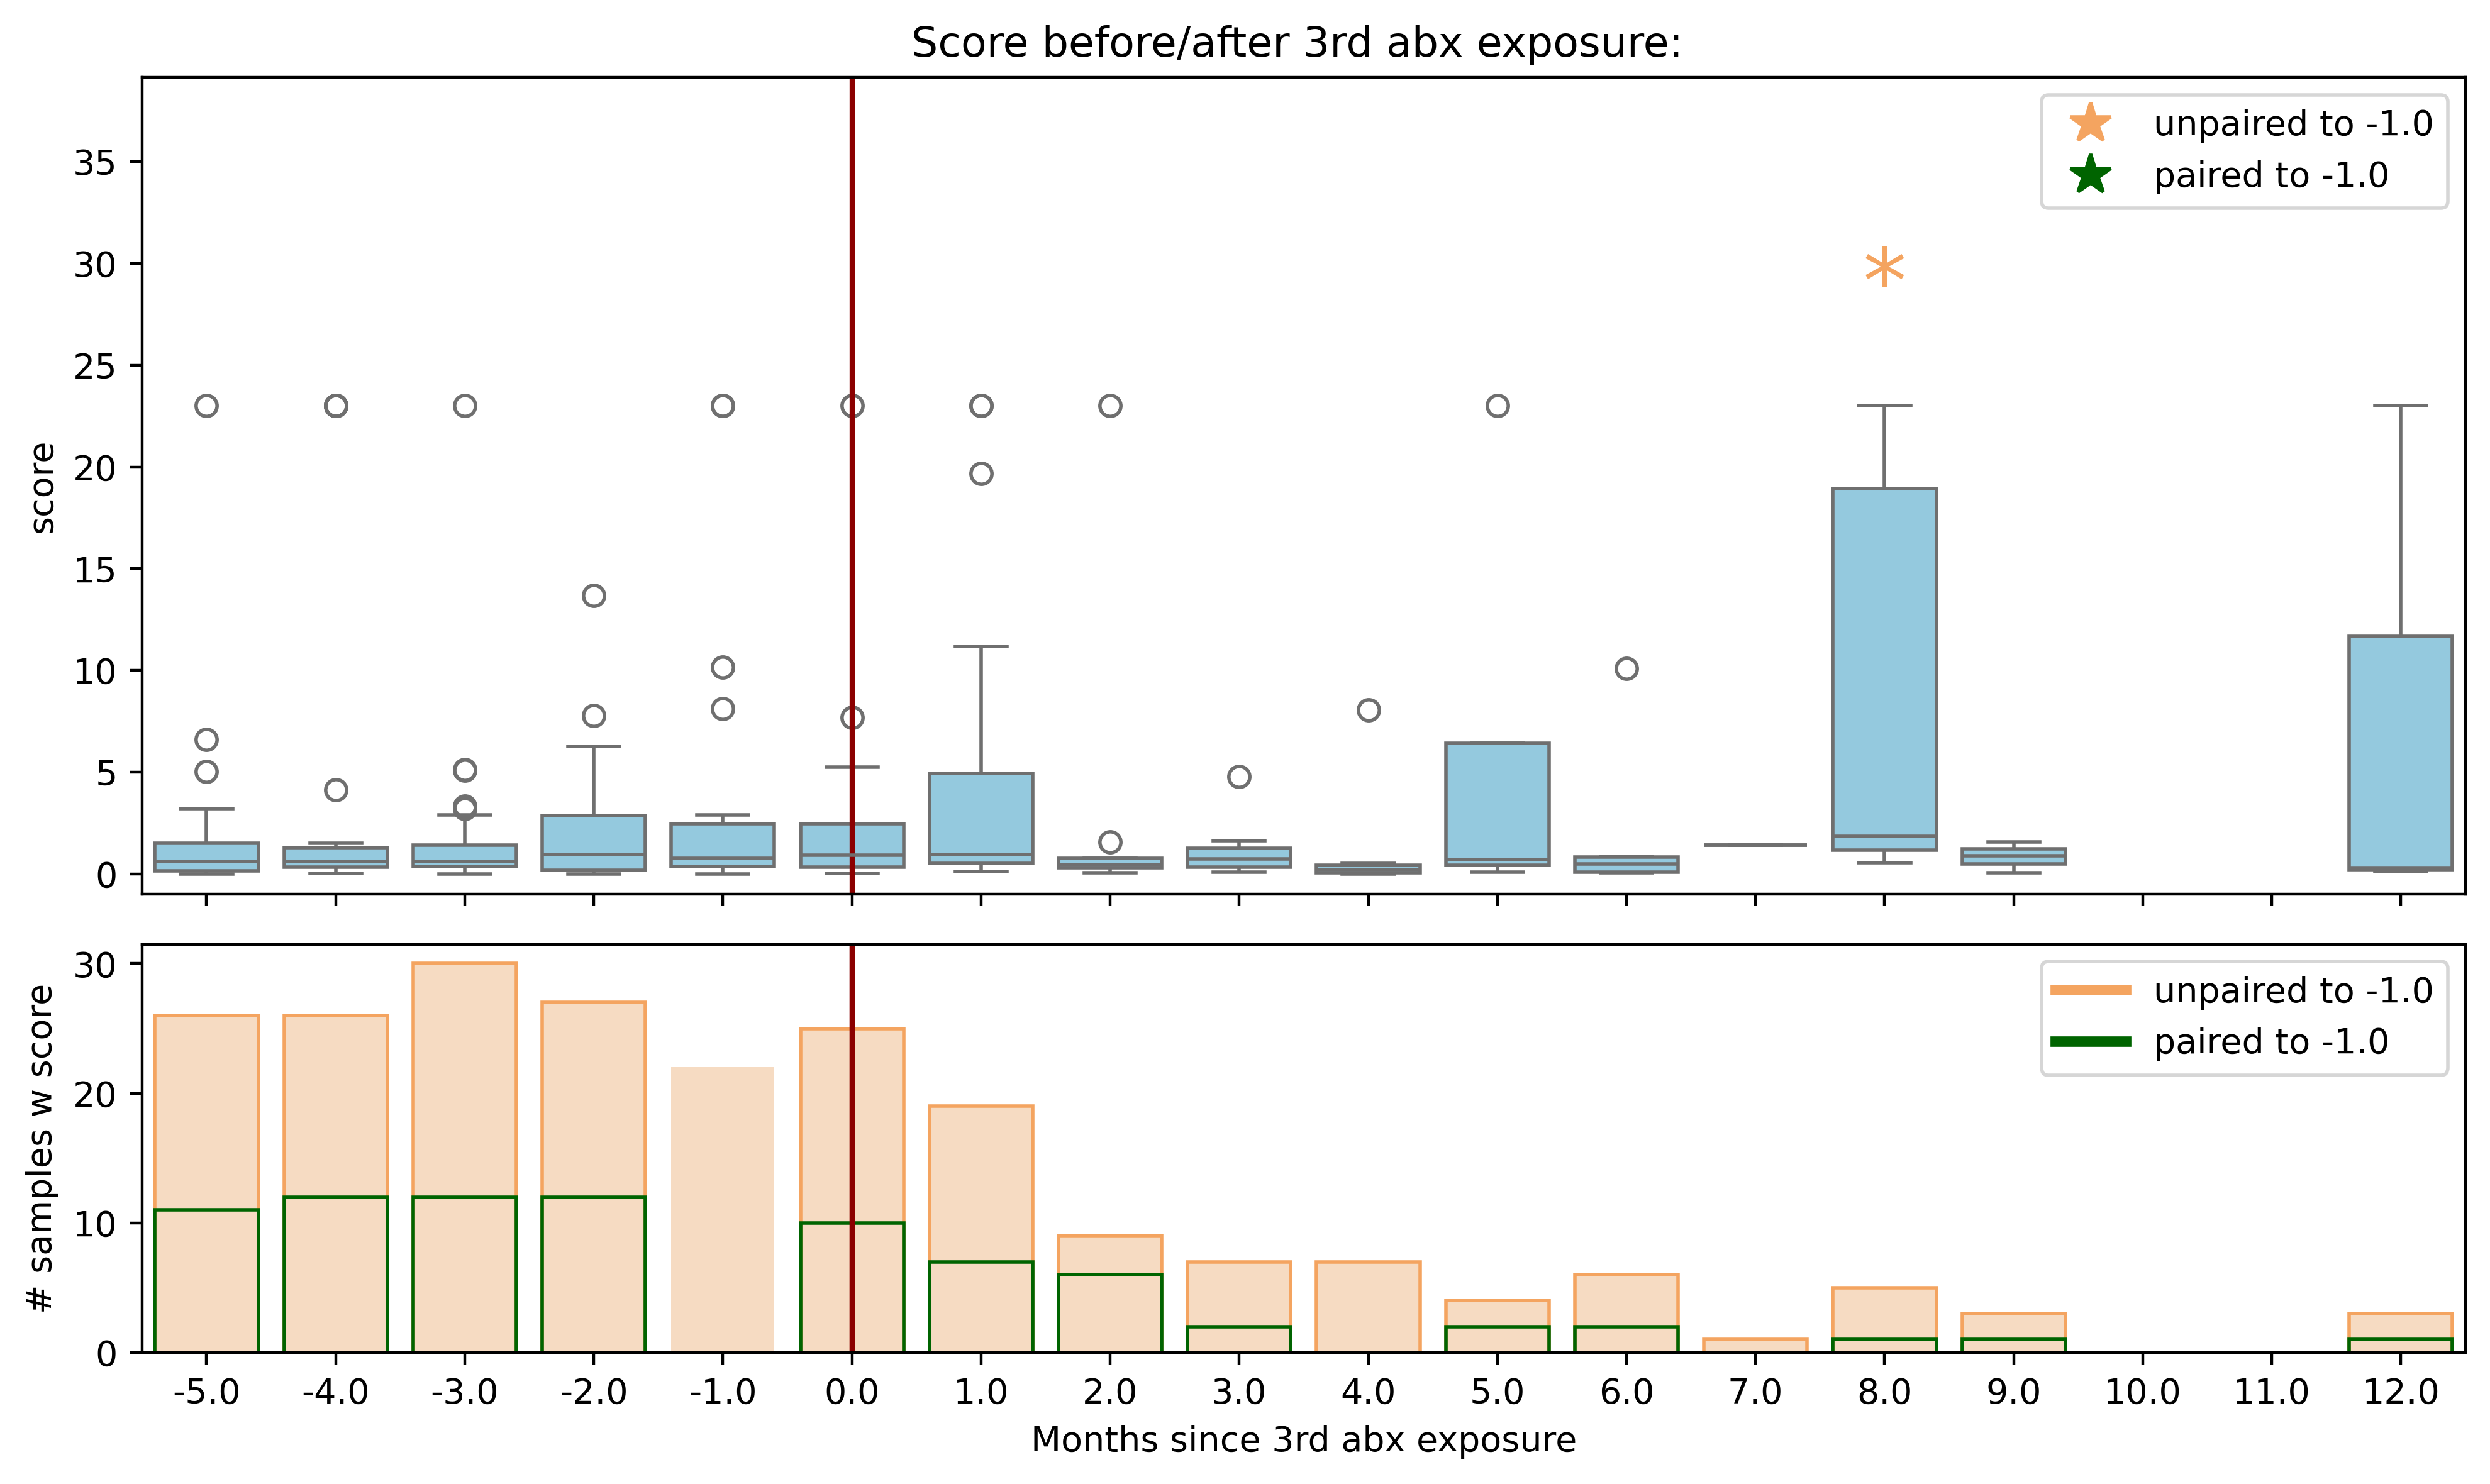

In [8]:
# get samples around n-th abx exposure
min_samples = -5.0
max_samples = 12.0
for n in [1, 2, 3]:
    scores_abx_nth_samples = _select_samples_around_nth_abx_exposure(
        abx_scores_flat, abx_df, n=n, 
        min_samples=min_samples,
        max_samples=max_samples
    )
    _plot_score_after_nth_abx_exposure(
        scores_abx_nth_samples,
        x_axis="diff_age_nth_abx",
        y_axis="score",
        n=n,
        path_to_save=evaluation_path,
        flag=split,
        min_samples=min_samples,
        max_samples=max_samples
    )

## Score after 1st abx: split by duration: < 7 days vs. >= 7 days

abx_duration_category
NaN          198
>= 6 days    157
< 6 days      94
Name: count, dtype: int64

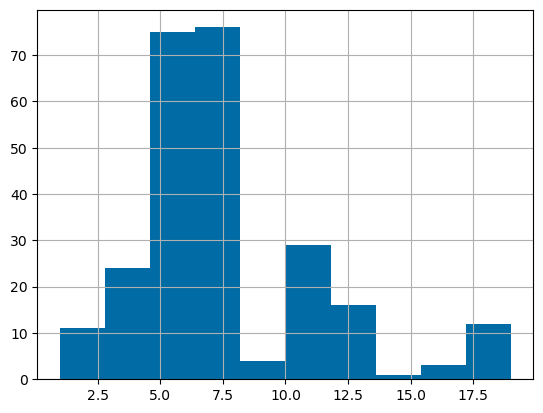

In [9]:
n = 1
scores_abx_nth_samples = _select_samples_around_nth_abx_exposure(
        abx_scores_flat, abx_df, n=n, min_samples=min_samples, max_samples=max_samples)

# bin duration into short, mid and long duration
scores_abx_nth_samples["abx_any_last_dur_days"].hist(bins=10)

bins = [-float('inf'), 6, float('inf')]
dur_labels = ['< 6 days', '>= 6 days']
scores_abx_nth_samples['abx_duration_category'] = pd.cut(scores_abx_nth_samples['abx_any_last_dur_days'], bins=bins, labels=dur_labels, right=False)

scores_abx_nth_samples['abx_duration_category'].value_counts(dropna=False)

< 6 days
>= 6 days


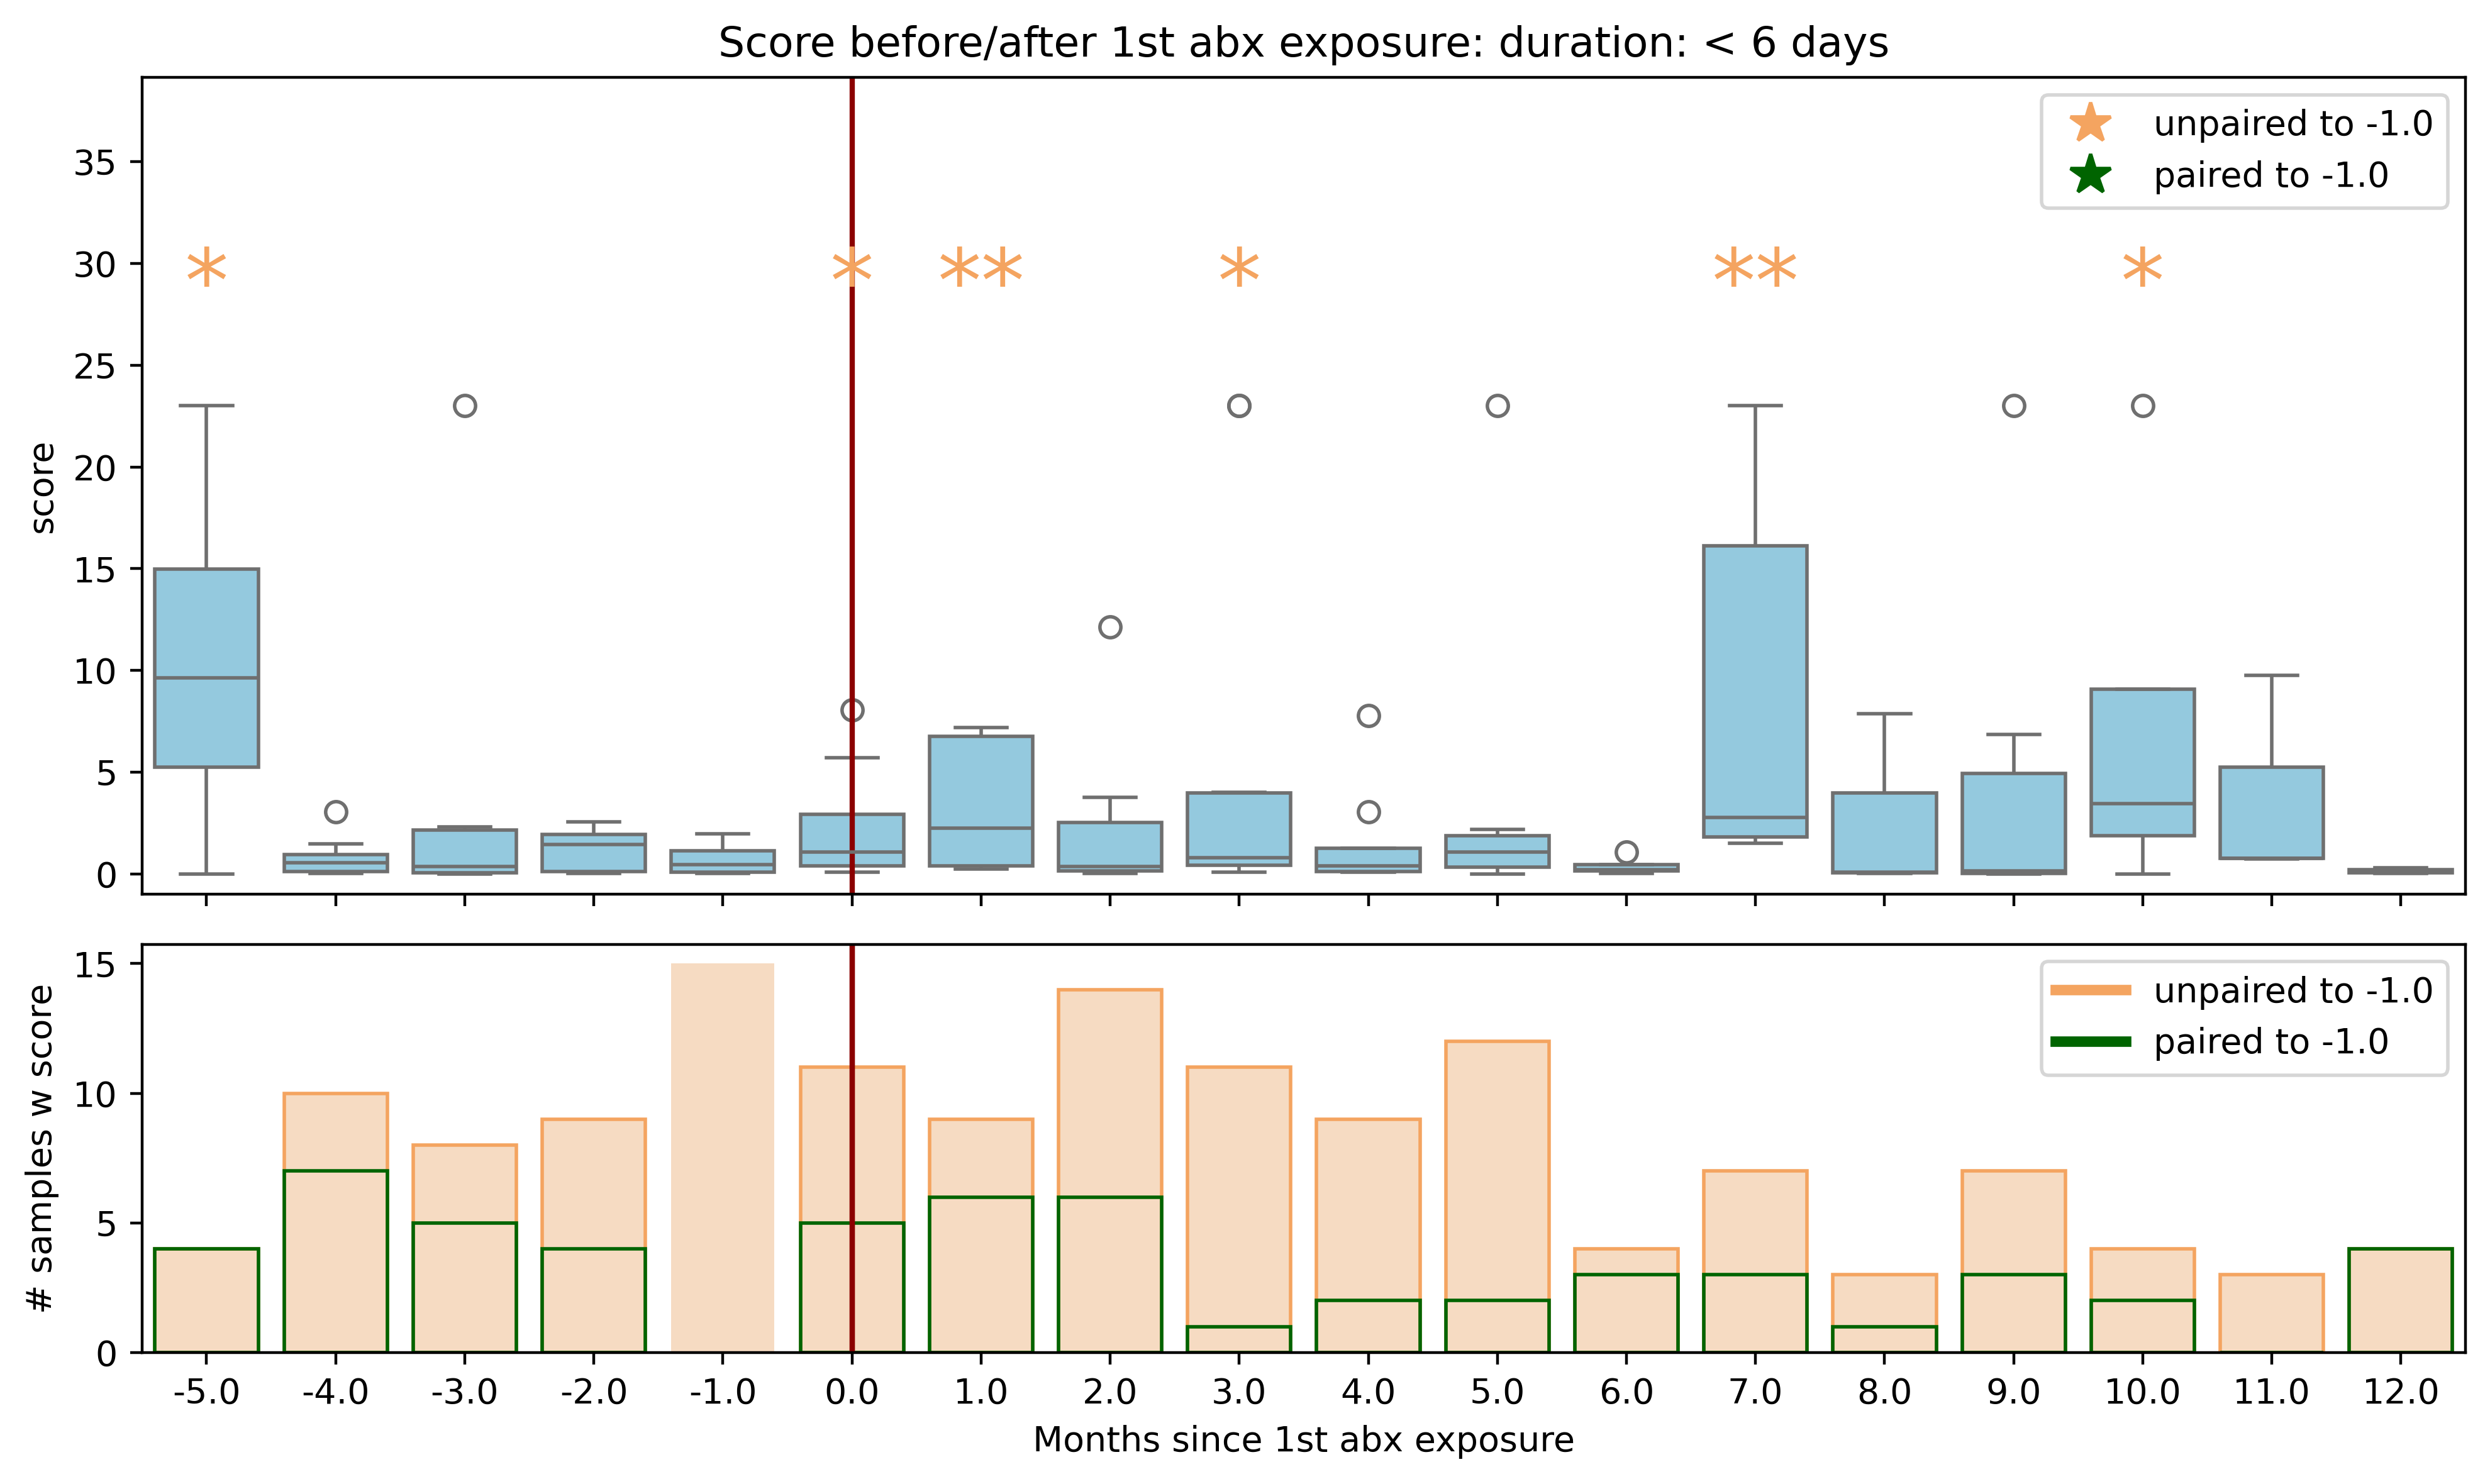

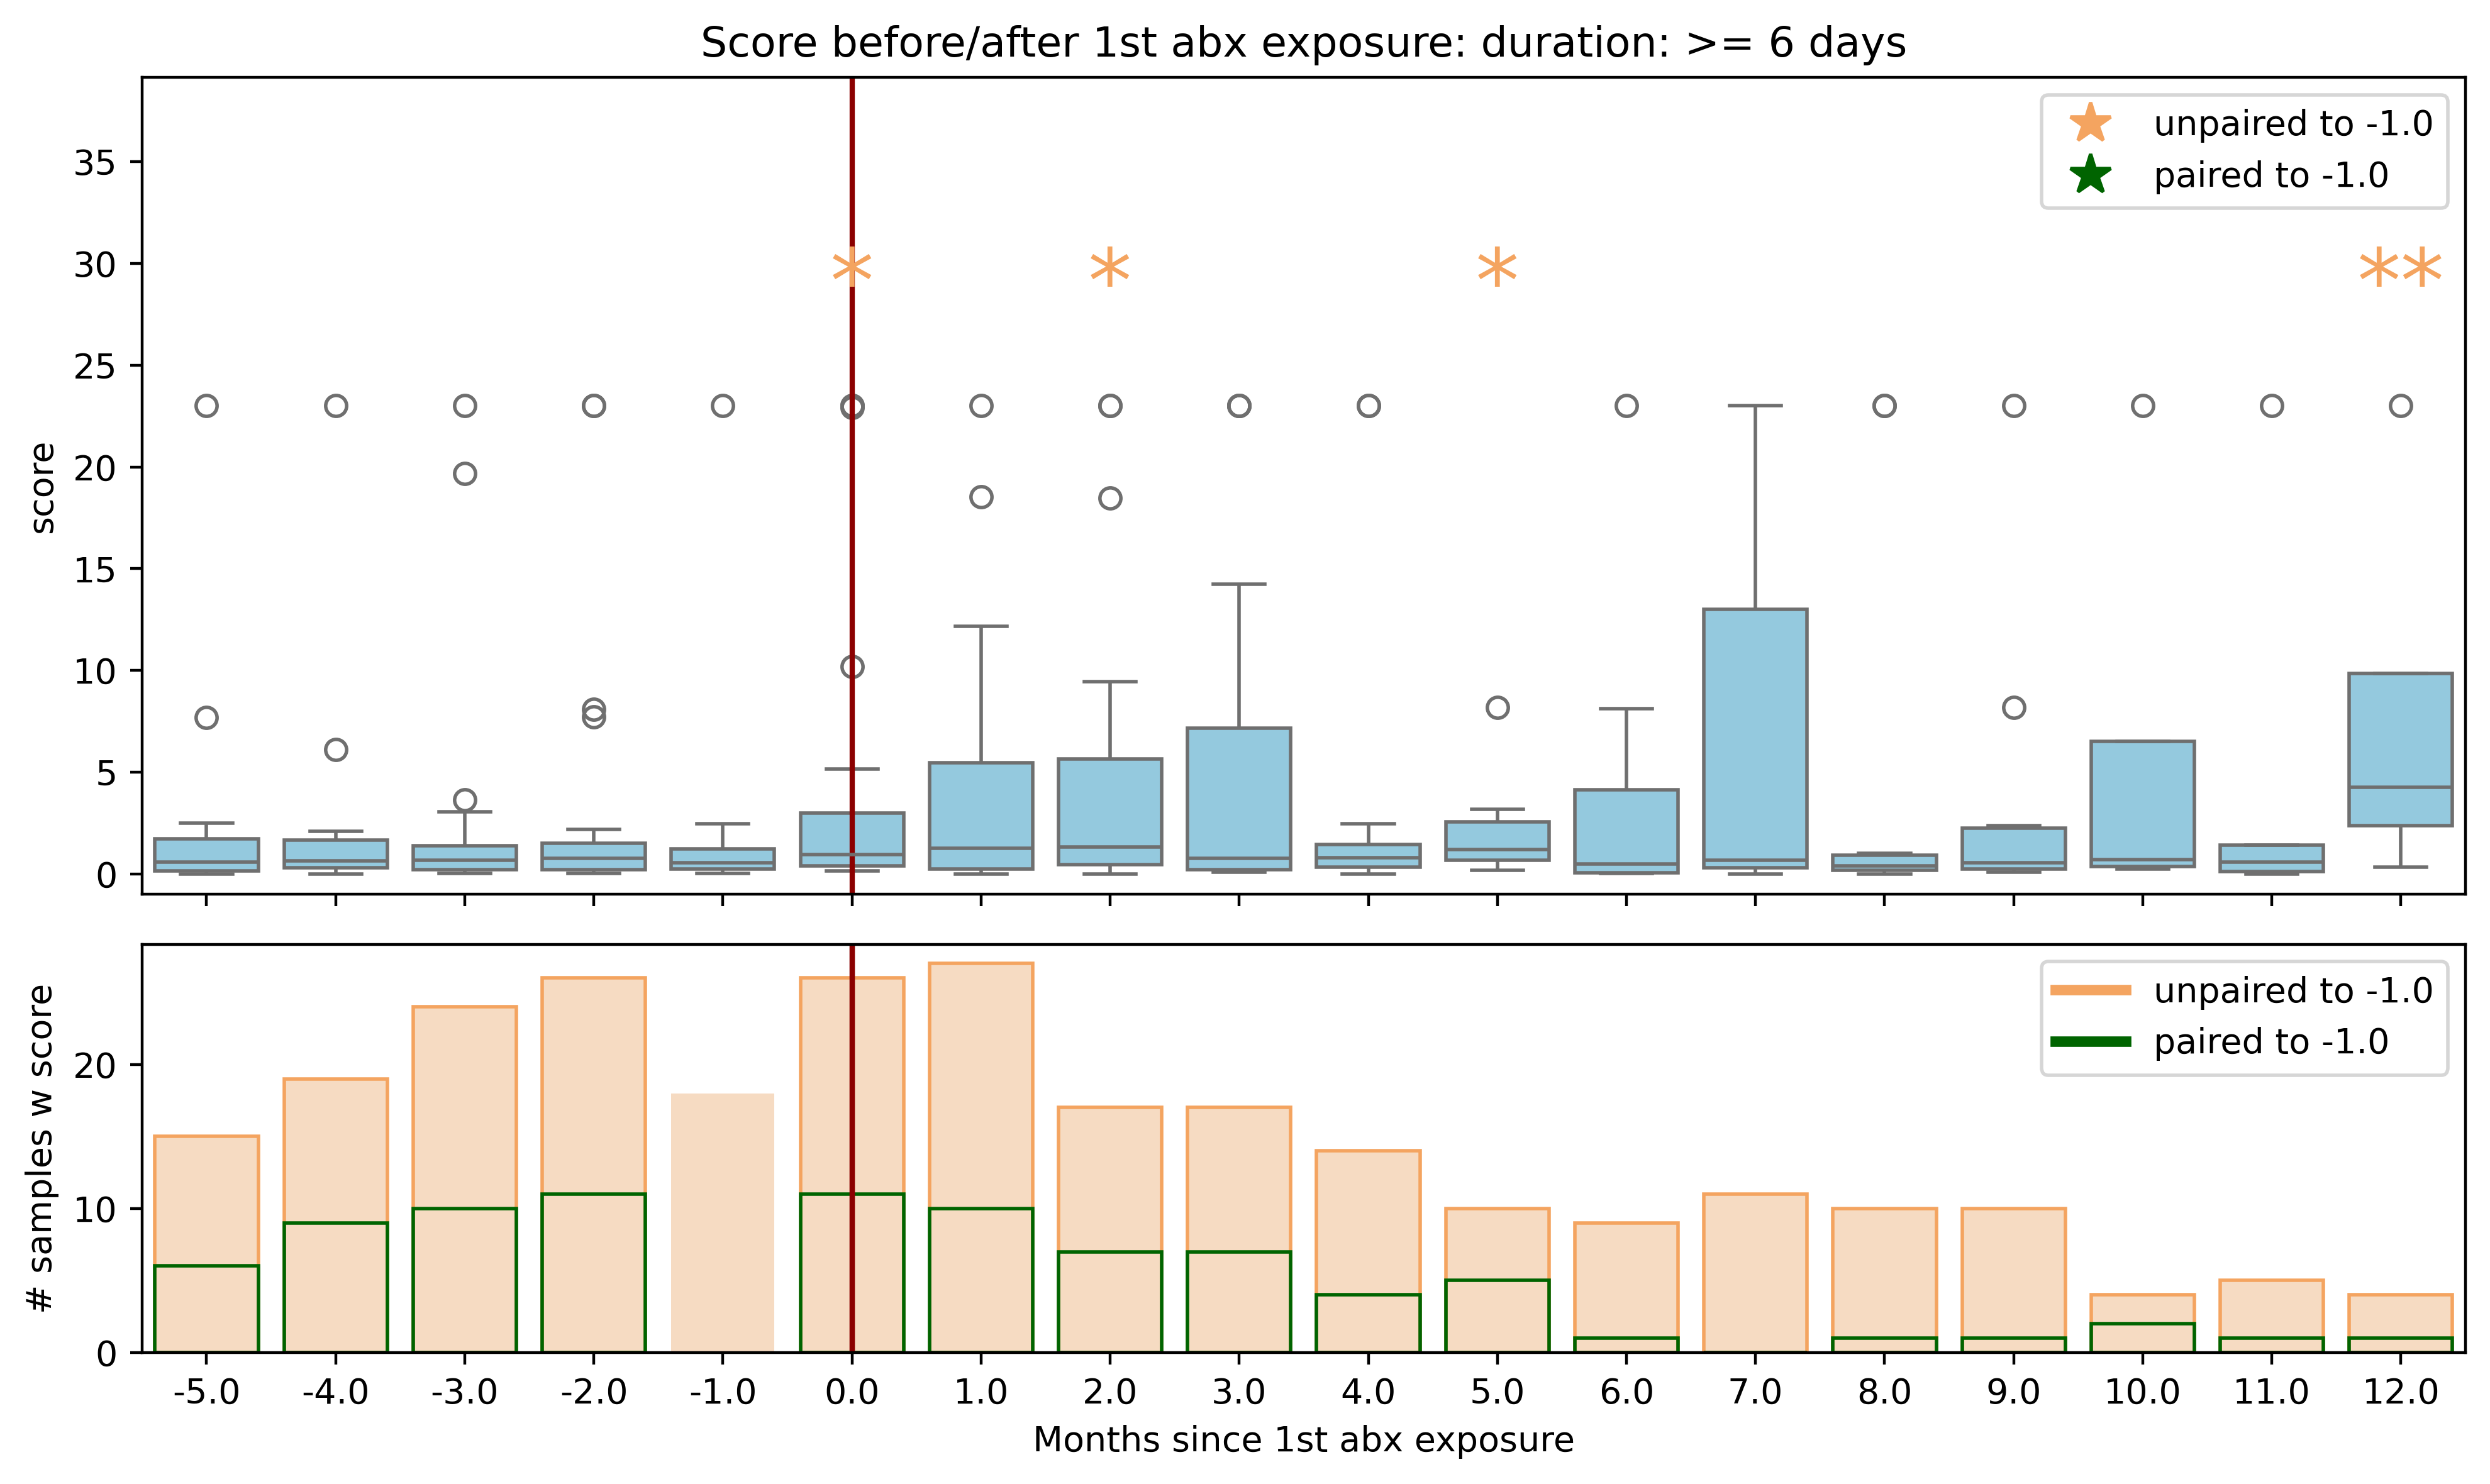

In [10]:
i = 0
for dur in dur_labels:
    print(dur)
    evaluation_path_bin = f"{evaluation_path}duration_bins{i}_"
    host_w_dur = scores_abx_nth_samples.loc[scores_abx_nth_samples['abx_duration_category'] == dur, "host_id"].unique().tolist()
    scores_abx_nth_samples_dur = scores_abx_nth_samples.loc[scores_abx_nth_samples['host_id'].isin(host_w_dur)].copy()

    _plot_score_after_nth_abx_exposure(
        scores_abx_nth_samples_dur,
        x_axis="diff_age_nth_abx",
        y_axis="score",
        n=n,
        path_to_save=None,
        flag=split,
        tag = f"duration: {dur}",
        min_samples=min_samples,
        max_samples=max_samples
    )

    i += 1

### Score after 1st abx: split by time of life

age_nth_abx_category
< 12 months     249
>= 12 months    200
Name: count, dtype: int64

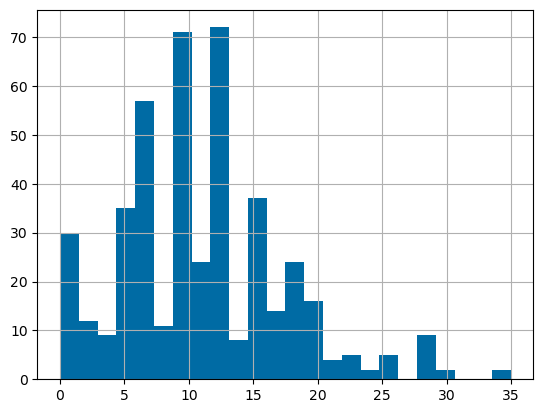

In [11]:
n = 1
scores_abx_nth_samples = _select_samples_around_nth_abx_exposure(
        abx_scores_flat, abx_df, n=n, min_samples=min_samples, max_samples=max_samples)

# bin duration into short, mid and long duration
scores_abx_nth_samples["age_nth_abx"].hist(bins=24)

bins_age = [-float('inf'), 12, float('inf')]
# <6: pre weaning
age_labels = ['< 12 months', '>= 12 months']
scores_abx_nth_samples['age_nth_abx_category'] = pd.cut(scores_abx_nth_samples['age_nth_abx'], bins=bins_age, labels=age_labels, right=False)

scores_abx_nth_samples['age_nth_abx_category'].value_counts(dropna=False)

< 12 months
>= 12 months


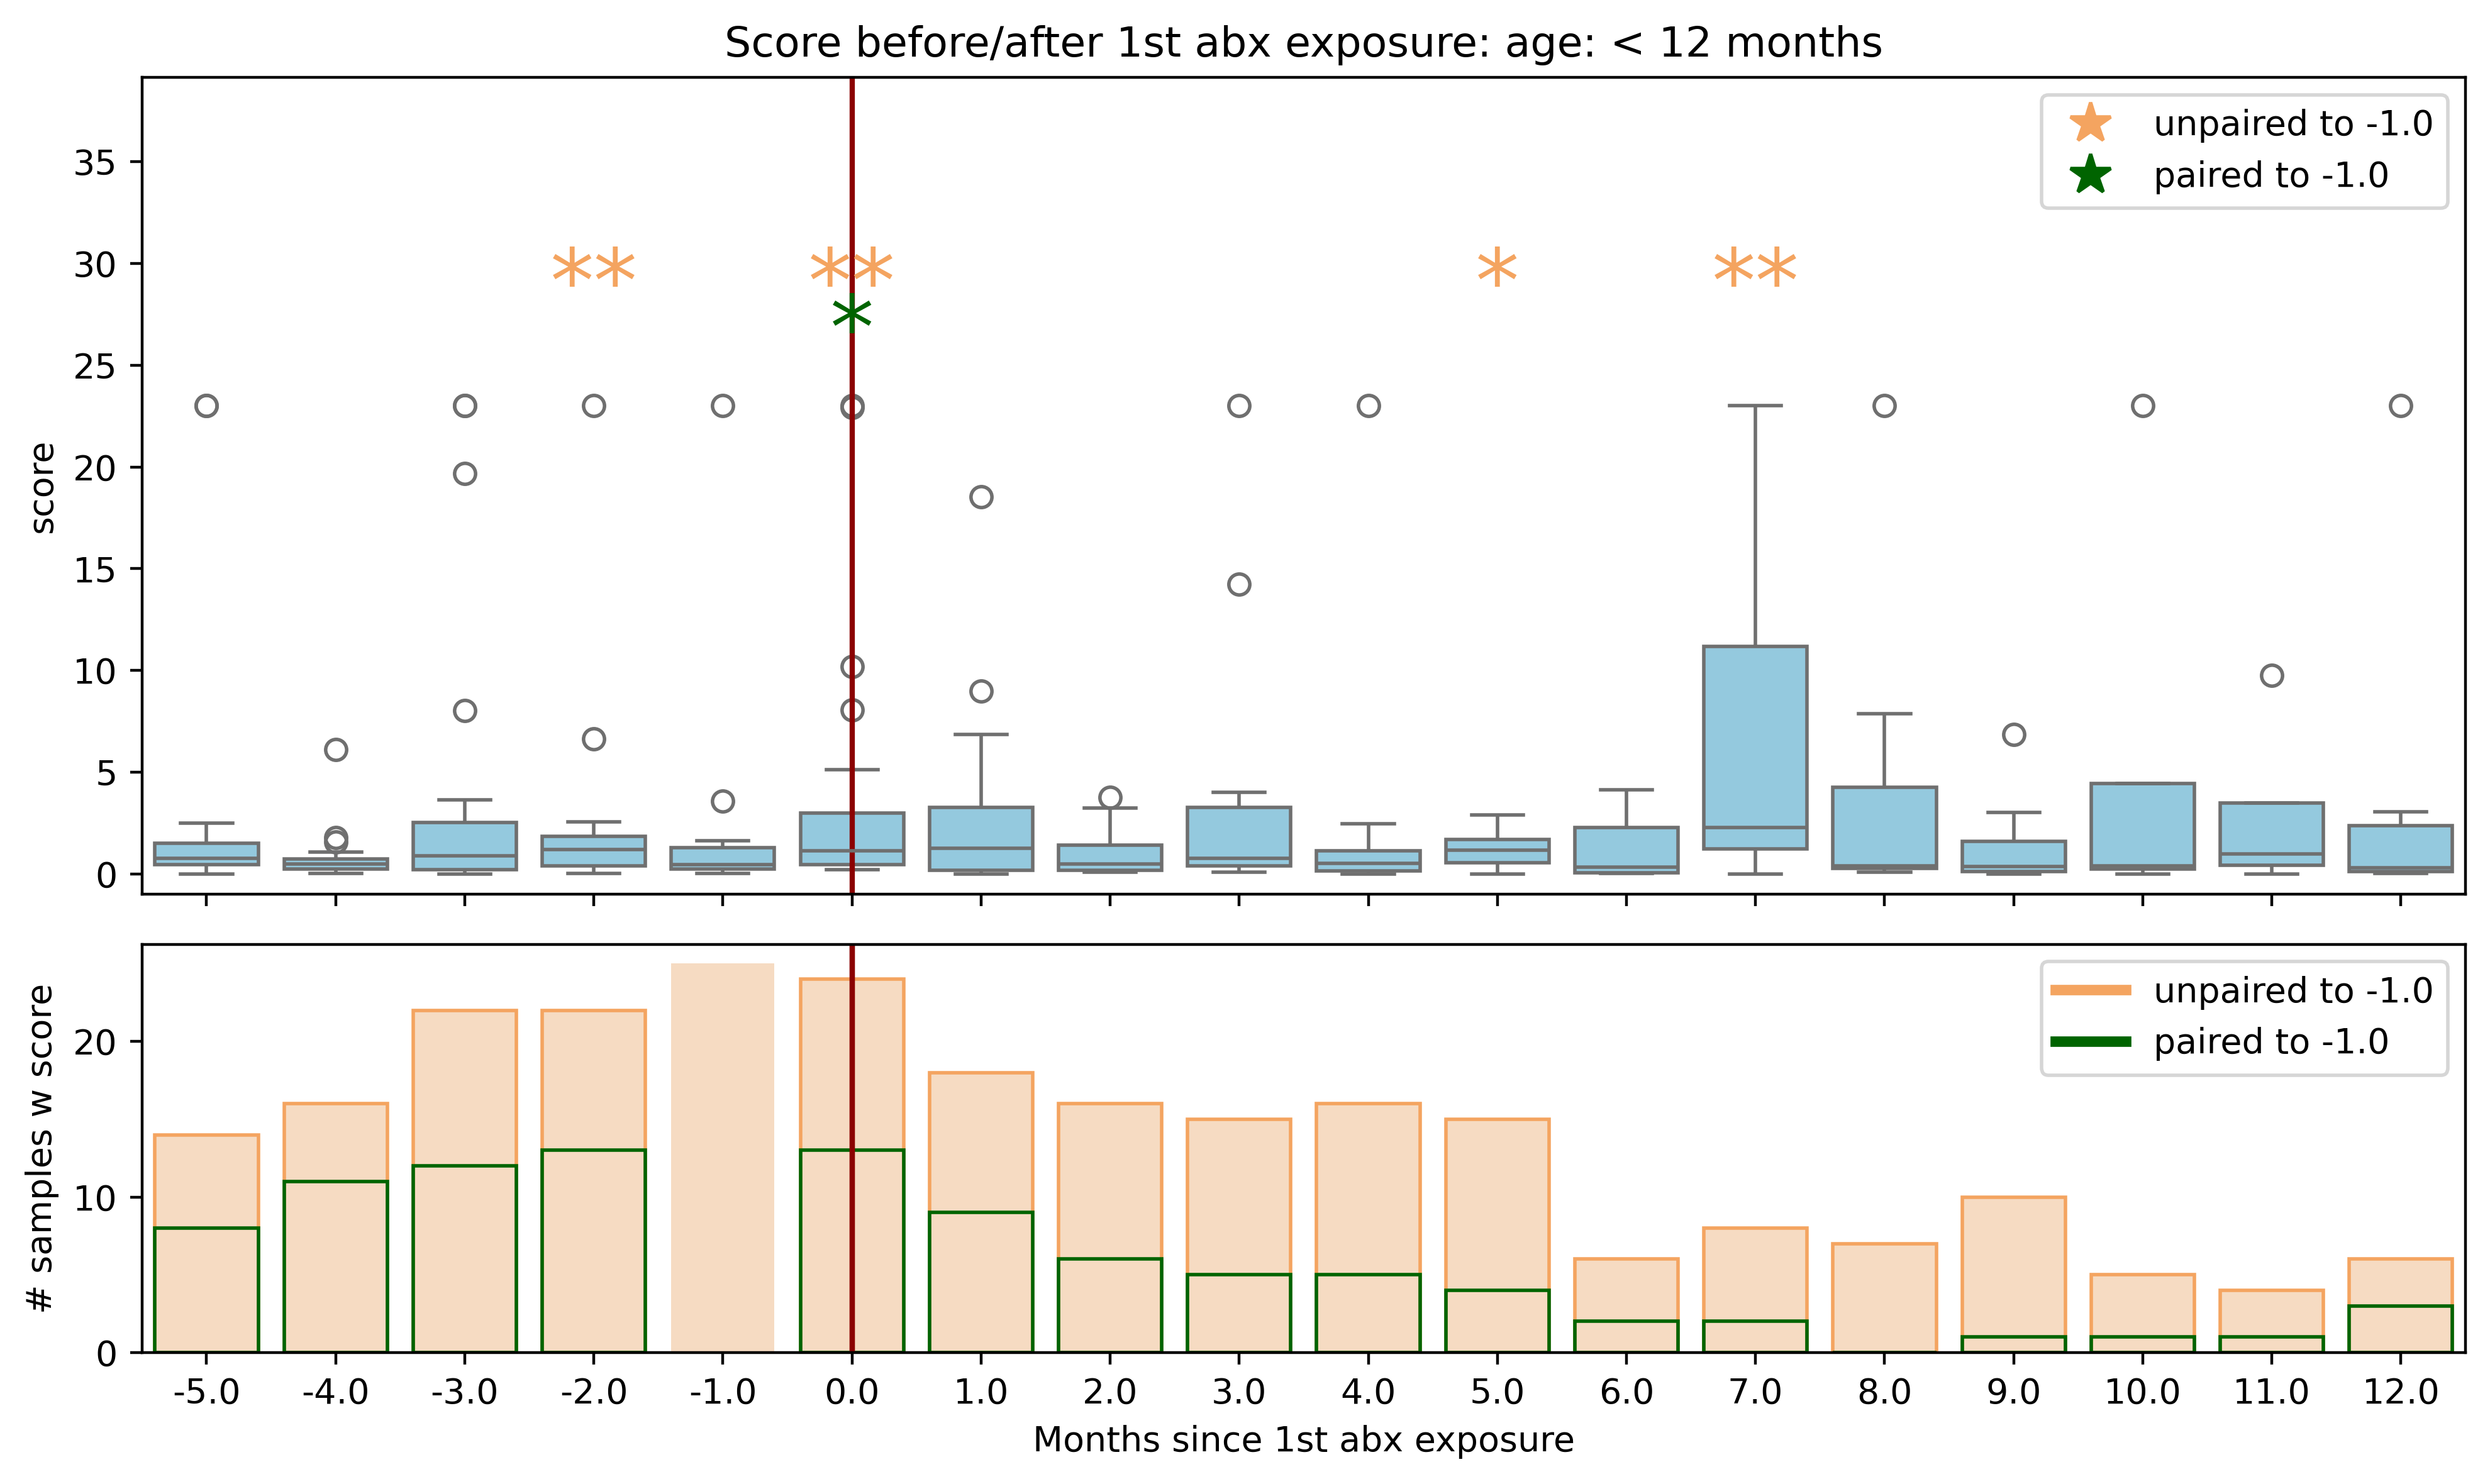

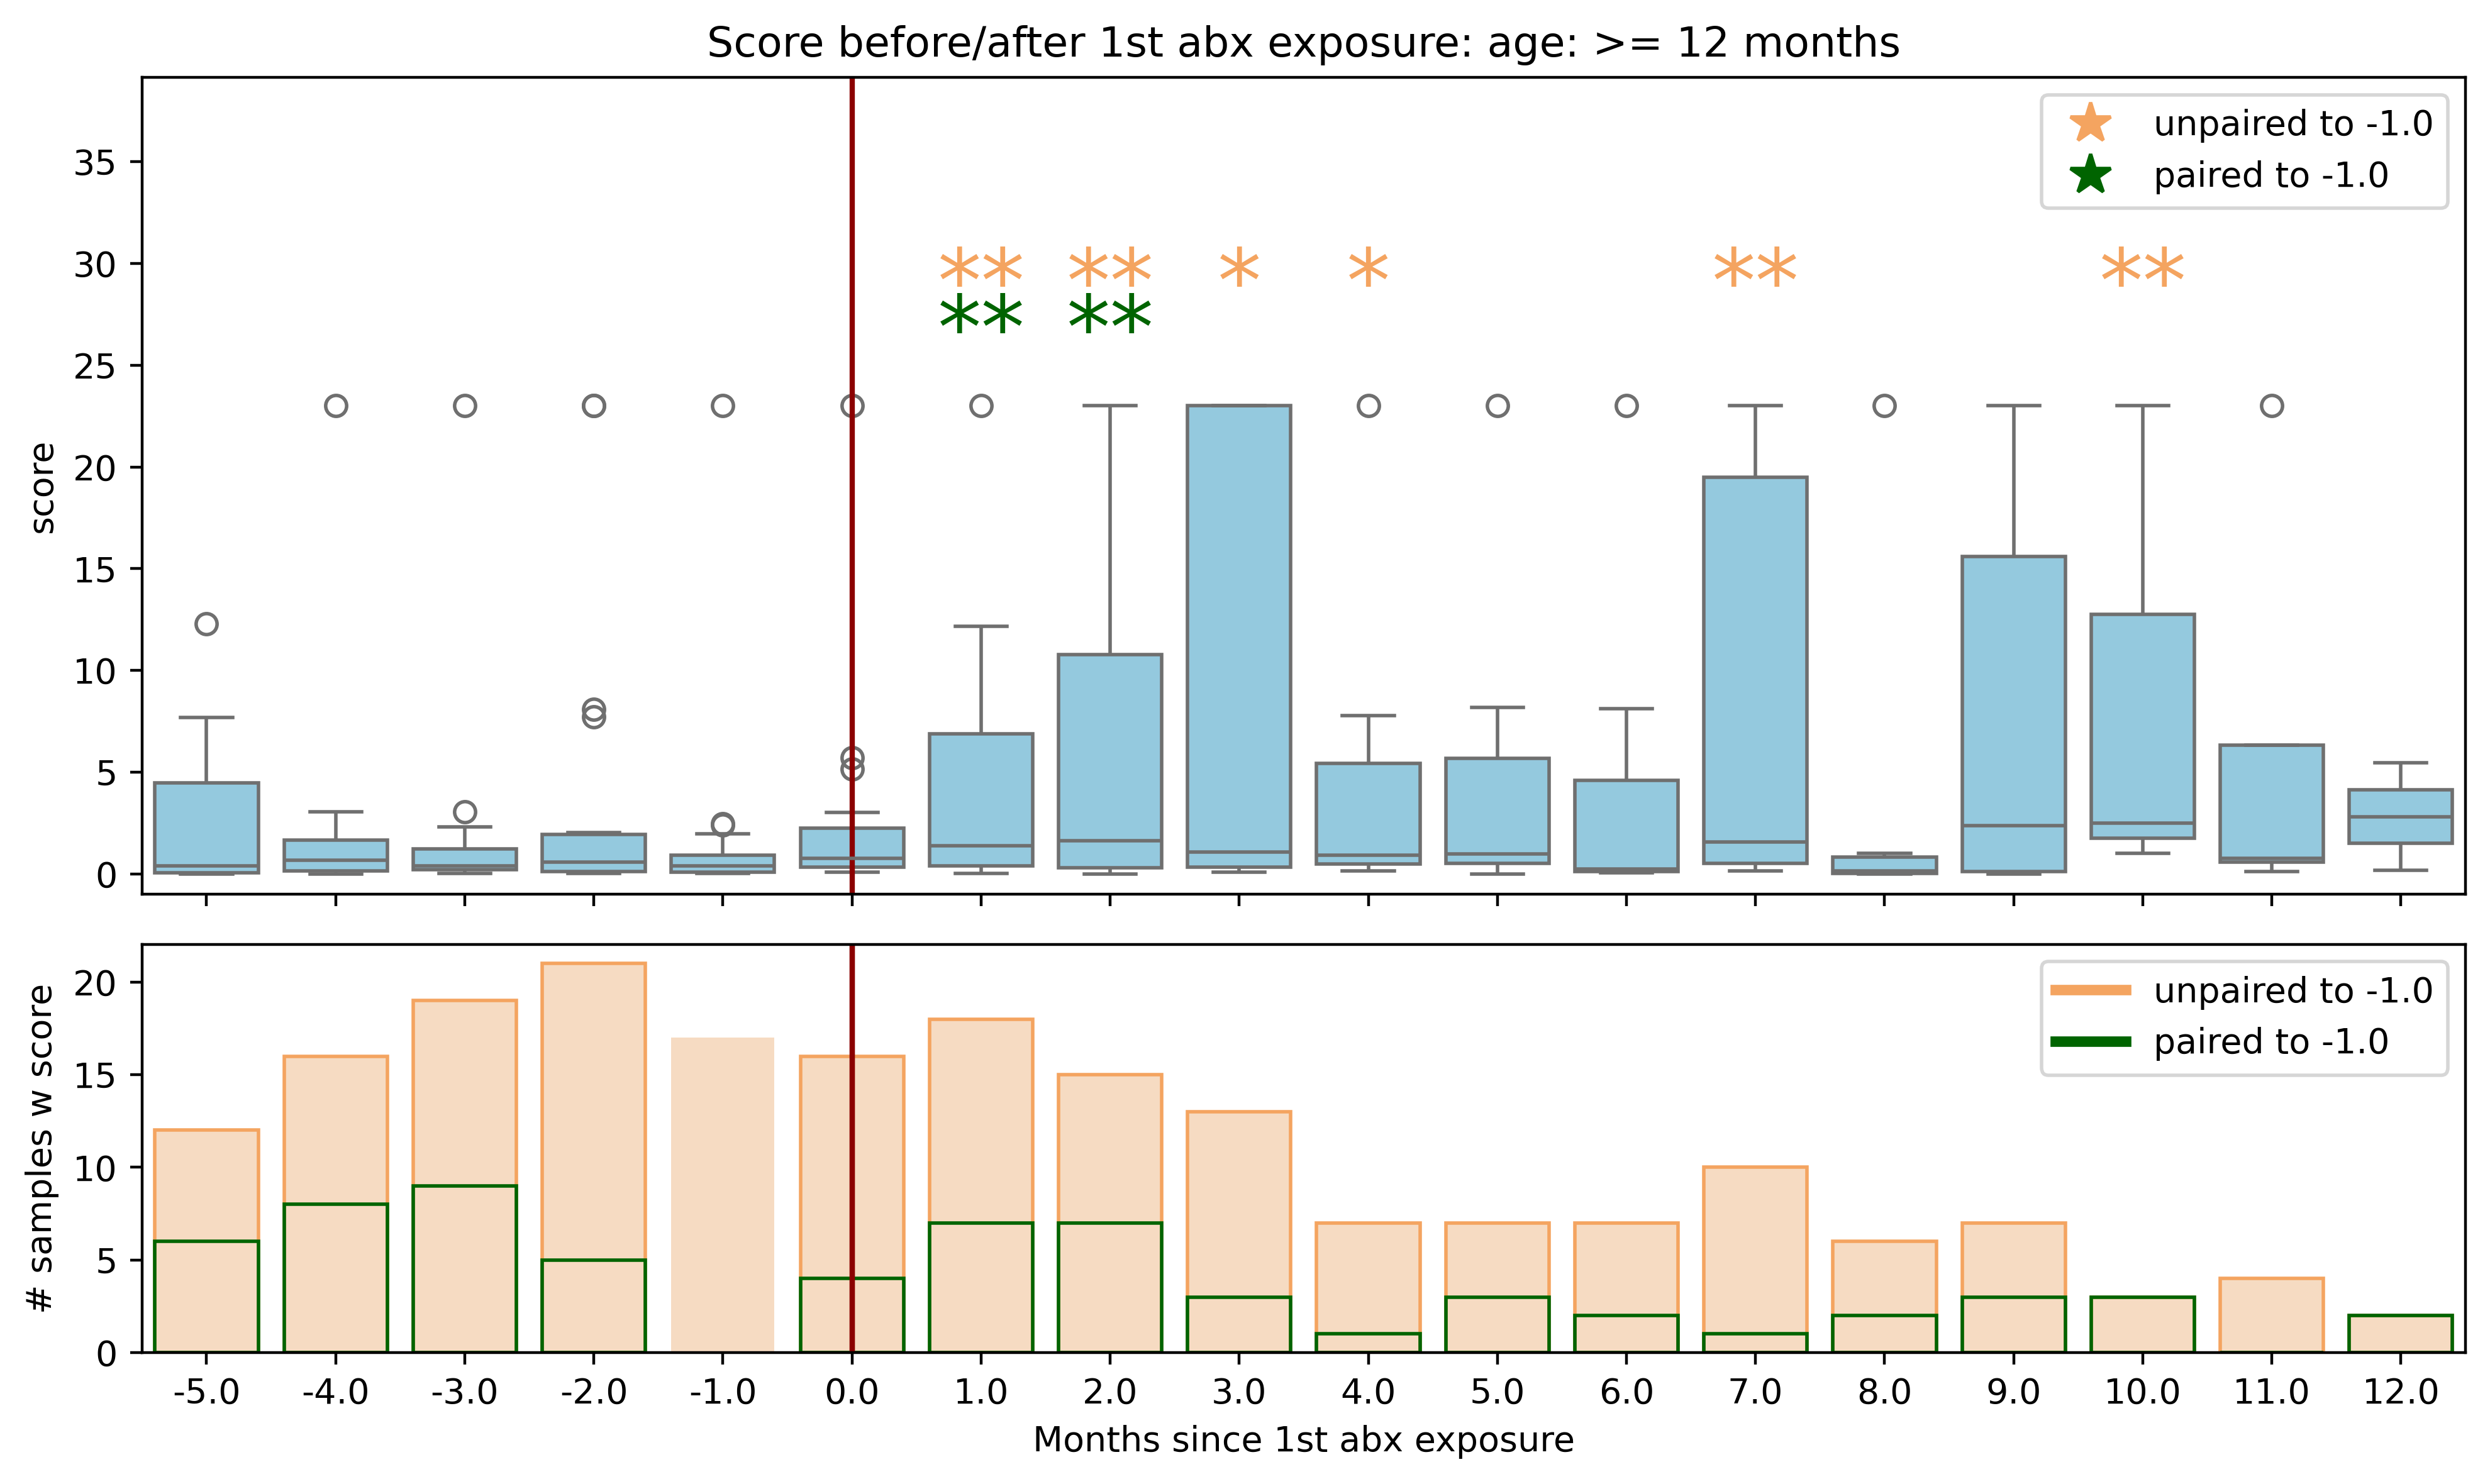

In [12]:
i = 0
for a in age_labels:
    print(a)
    evaluation_path_bin = f"{evaluation_path}age_bins{i}_"
    
    # age at time of abx exposure should match a
    scores_abx_nth_samples_age = scores_abx_nth_samples.loc[scores_abx_nth_samples['age_nth_abx_category']==a].copy()

    _plot_score_after_nth_abx_exposure(
        scores_abx_nth_samples_age,
        x_axis="diff_age_nth_abx",
        y_axis="score",
        n=n,
        path_to_save=None,
        flag=split,
        tag = f"age: {a}",
        min_samples=min_samples,
        max_samples=max_samples
    )

    i += 1

## Score over age range

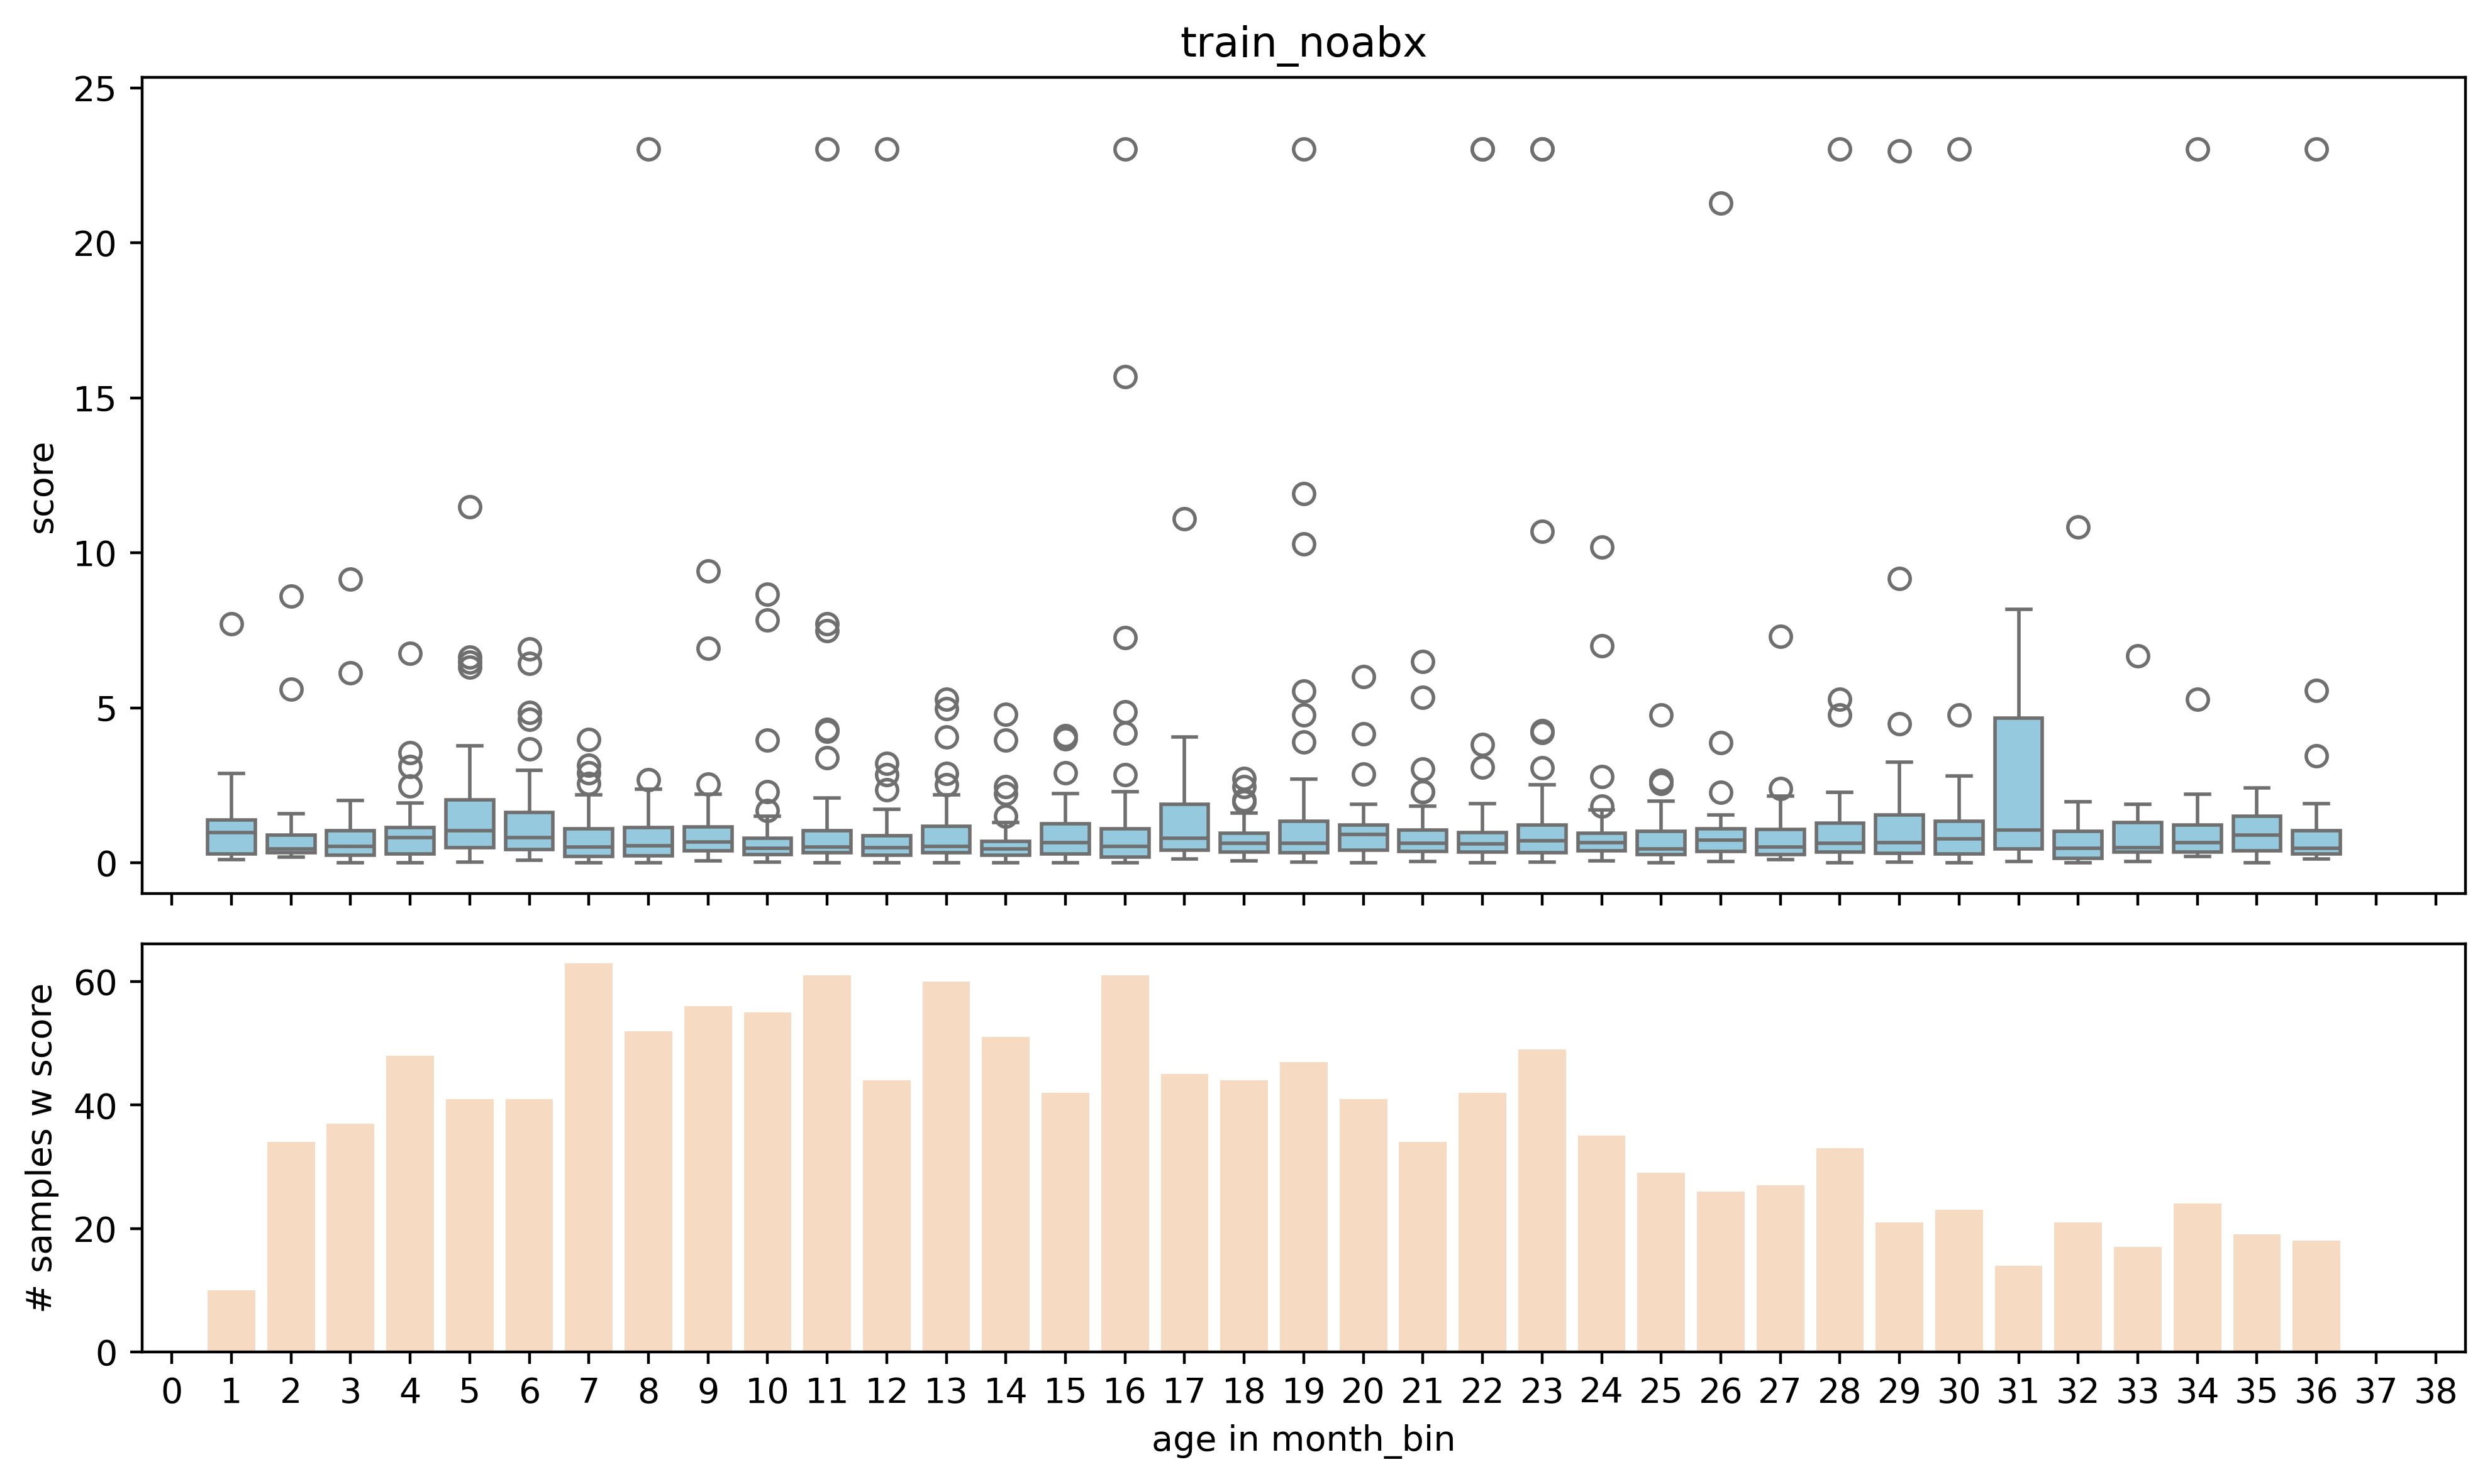

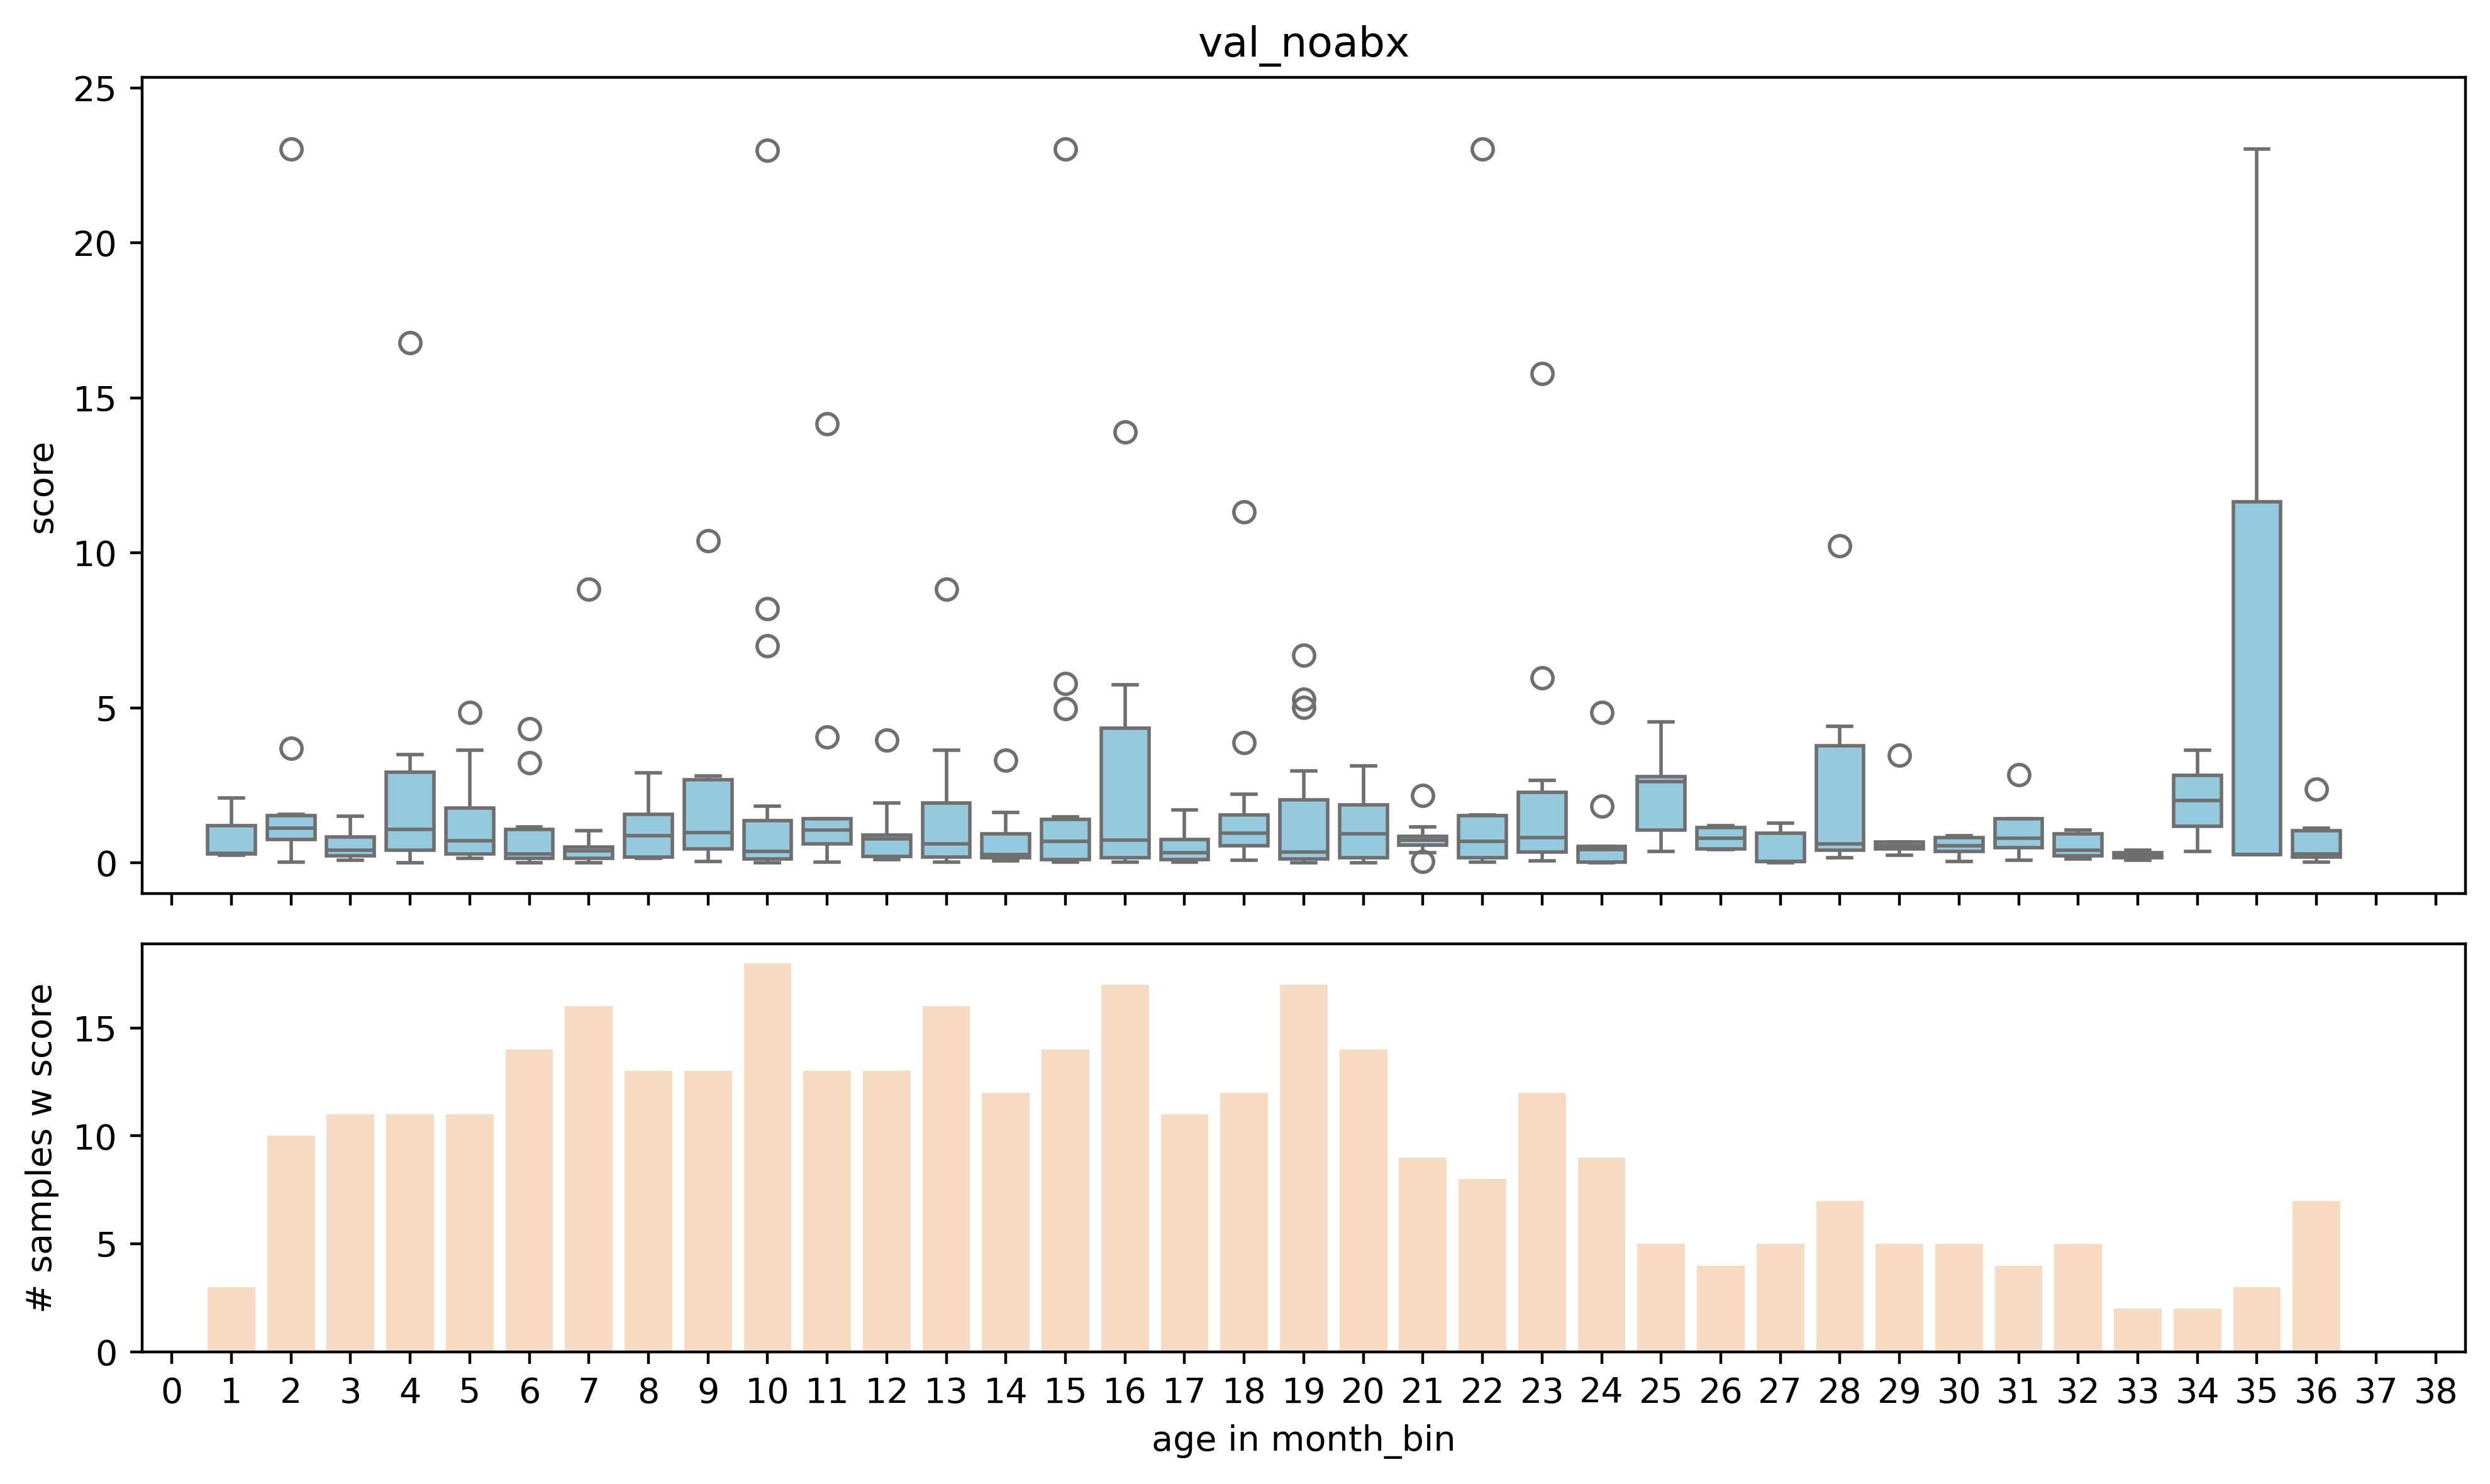

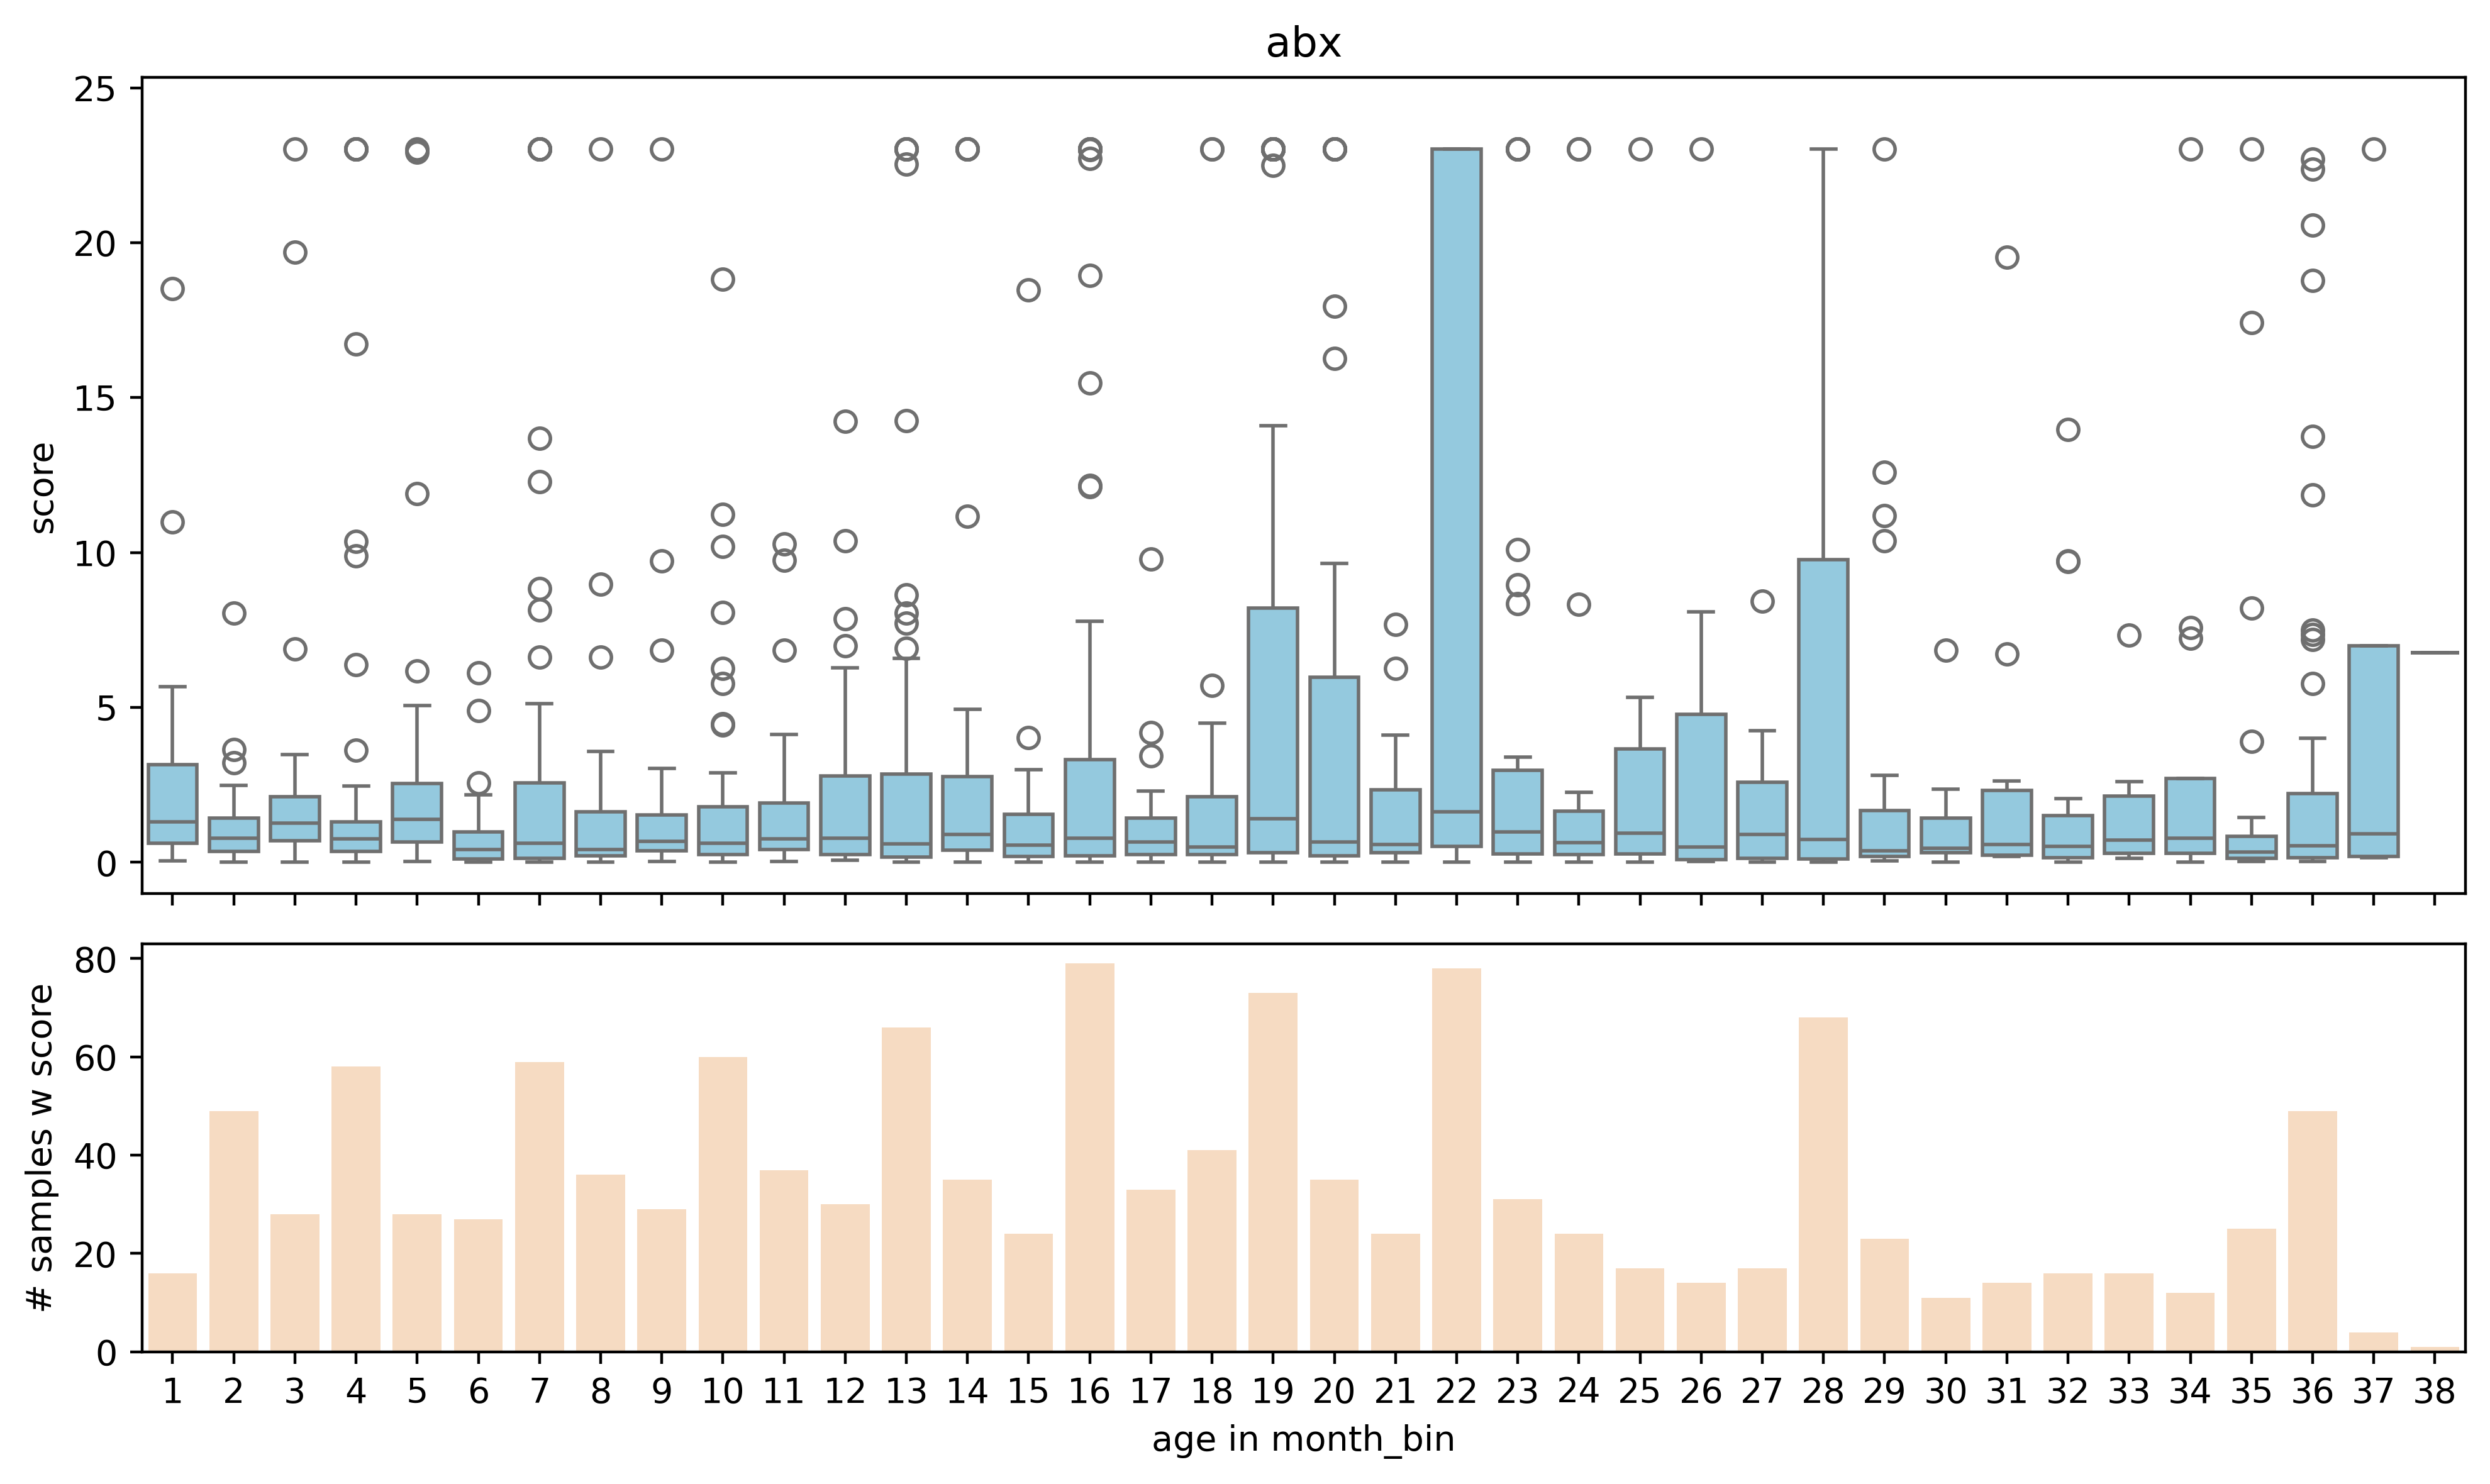

In [13]:
dic_splits_n_scores = {
    "train_noabx": noabx_train,
    "val_noabx": noabx_val,
    "abx": abx_scores_flat
}

for name, scores in dic_splits_n_scores.items():
    _plot_score_over_age(scores, name, evaluation_path)

## Score overall - scatter

In [14]:
# sort both abx dataframes by increasing abx exposure in same way
abx_scores_flat.sort_values(
    [
        "abx_max_count_ever",
        "max_abx_w_microbiome",
        "host_id",
        "day",
    ],
    ascending=[True, True, True, True],
    inplace=True,
)

# sort abx_df accordingly
# sort abx_df in same order and remove samples that don't exist in md_df
abx_events = pd.DataFrame()
abx_events["host_id"] = abx_scores_flat["host_id"].unique()
abx_events = pd.merge(abx_events, abx_df, on="host_id", how="left")

assert abx_events.host_id.unique().tolist() == abx_scores_flat.host_id.unique().tolist()


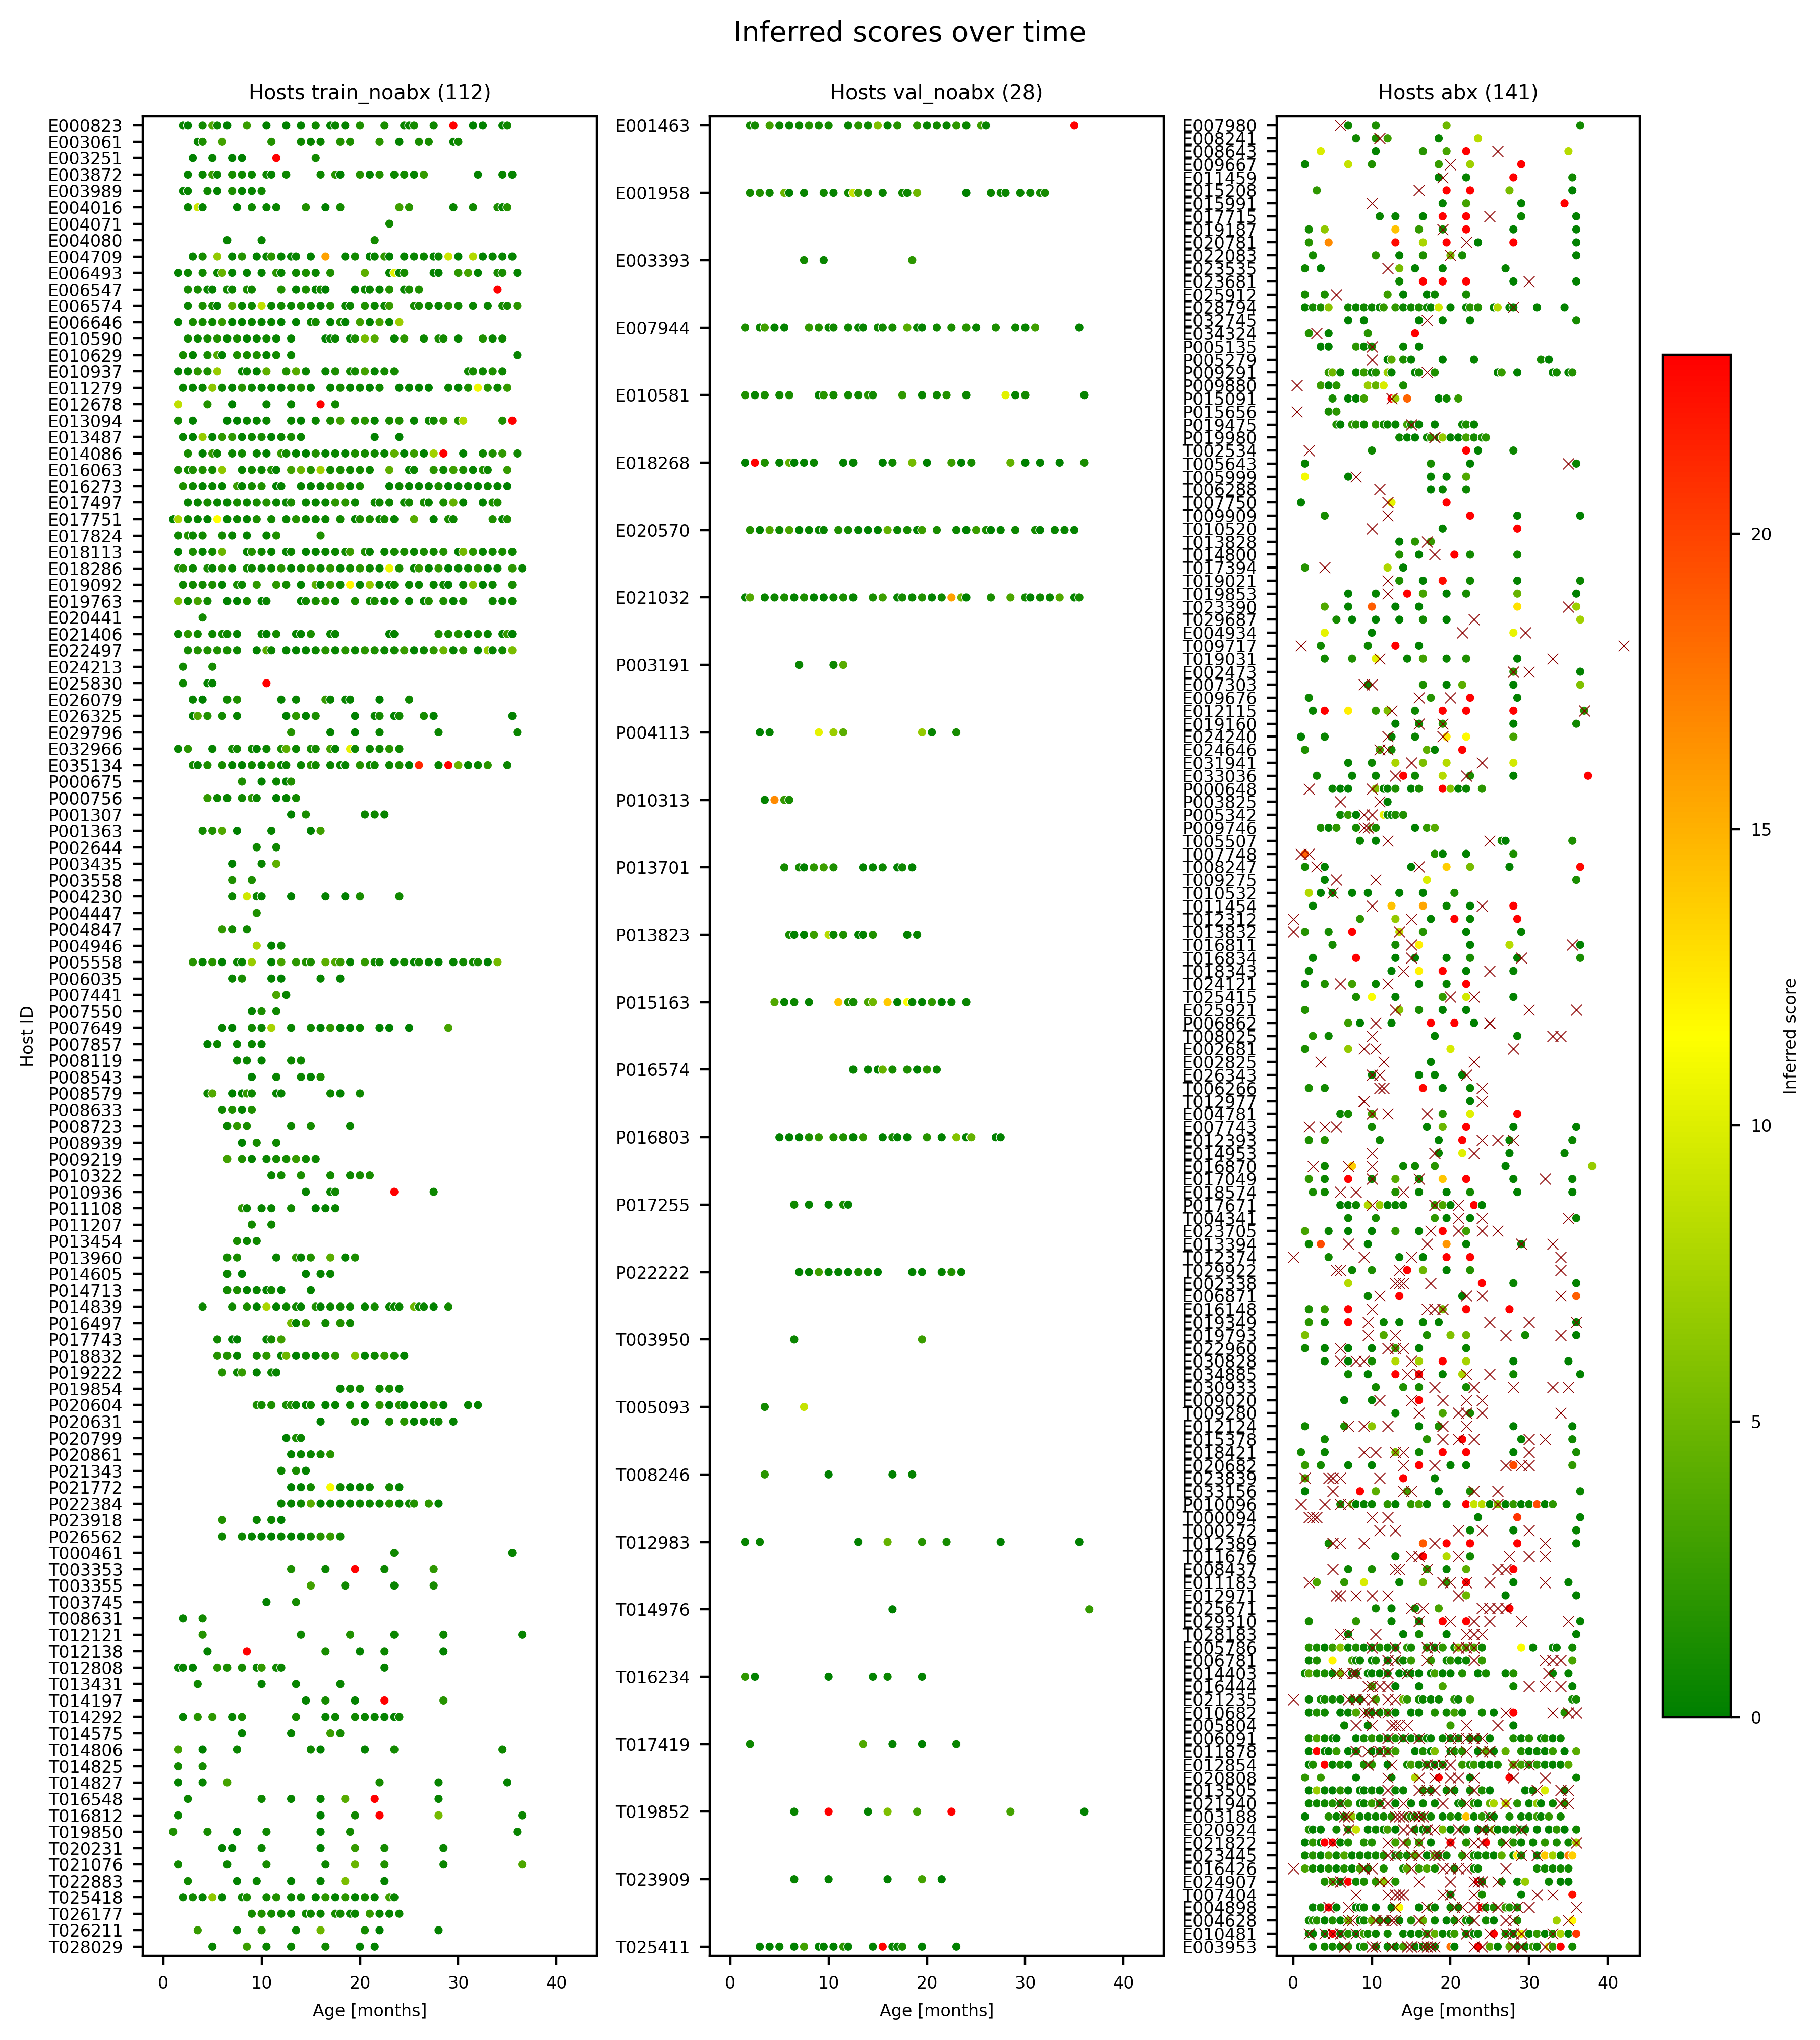

In [15]:
dic_splits = {
    "train_noabx": [noabx_train, None],
    "val_noabx": [noabx_val, None],
    "abx": [abx_scores_flat, abx_events]
}

display_scatterplot_w_scores(dic_splits, False)

## Individual trajectories: score

### abx

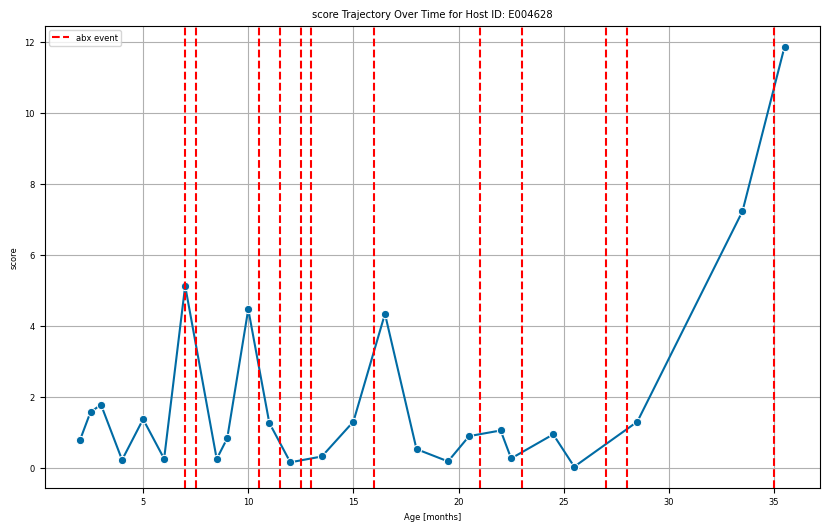

In [16]:
plot_trajectory(abx_scores_flat,abx_events,  "E004628", "score")

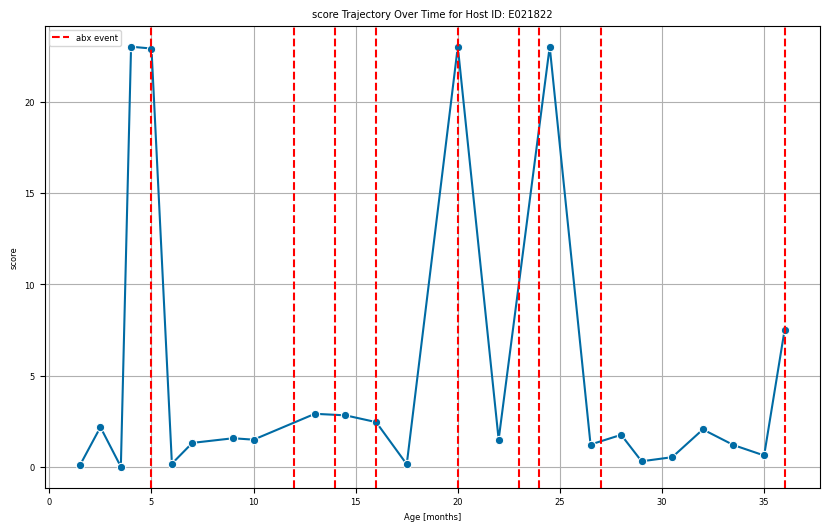

In [17]:
plot_trajectory(abx_scores_flat, abx_events,  "E021822", "score")

### noabx

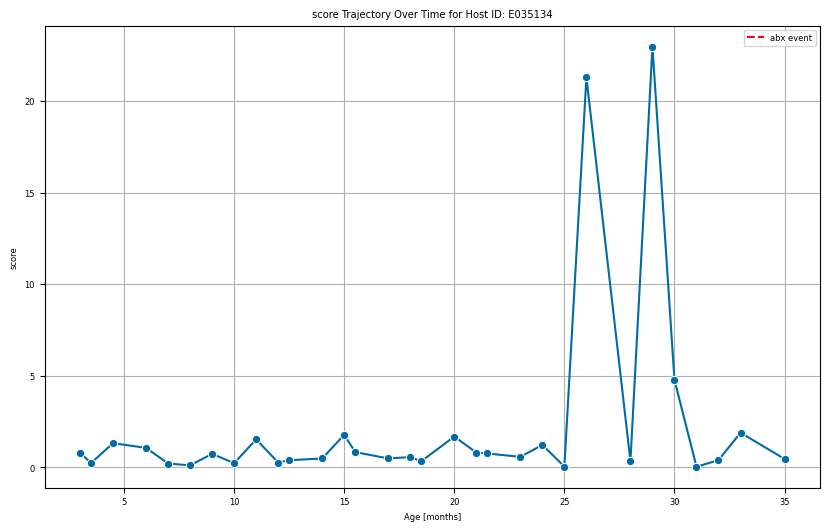

In [18]:
plot_trajectory(noabx_train, None,  "E035134", "score")

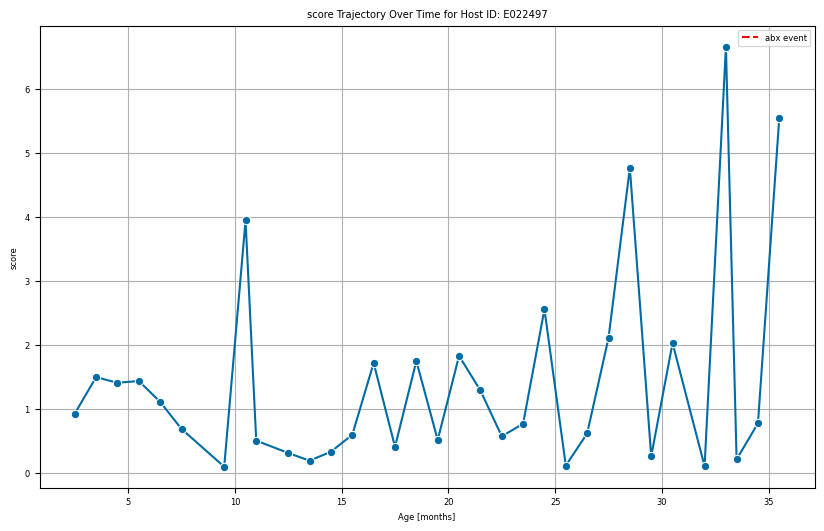

In [19]:
plot_trajectory(noabx_train, None,  "E022497", "score")